# Workflow RSAM & DSAR

**The first step is to calculate the data stream. There are several sub-steps:**
1. After removing the instrument response to the seismic signals, apply a bandpass filter to each 24 hours of data, between 2-5, 4.5-8 and 8-16 Hz (corresponding to the RSAM, MF and HF bands).
2. Compute the absolute values of each signal.
3. Subdivide the signals into 10 minutes intervals. For each interval, compute the average value as the RSAM, MF and HF datapoints assigned to that interval.
4. Removing outliers associated with regional earthquakes is optional. We procced as follow: from (2), subdivide the signals into 10 minutes intervals. 
    1. Calculated the mean and standard deviation (mu and sigma) for each interval. 
    2. Apply z-score normalization in log-space to the interval using mu and sigma. 
    3. Check if any value in the interval exceeds a threshold of 3.2 standard deviations above the mean. 
    4. If yes, exclude data points from a 150s mask starting 15s before the outlier located. 
    5. Calculate the average value in the interval excluding points inside the mask: this the RSAM, MF and HF value for the interval.
**To calculate the DSAR, procced as follow:**
1. Integrate the bandpass filtered MF and HF data with time.
2. Take the absolute value and compute averages on 10-minute intervals.
3. Compute the ratio between integrated MF and HF.
**For computing the DSAR median feature proposed as a precursor in this paper follow:**
1. Every 10 minutes in the DSAR data stream, take a 48 hours window (looking backwards).
2. For each window, compute the median.
3. Construct the feature time series with point every 10 minutes corresponding the medians computed from the 48 hours windows.


In [3]:
import numpy as np
import pandas as pd
import obspy
import obspy.signal.filter
import sys           
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import scipy
import glob
import os
import scipy as sc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
# read txt-file with UTC times and type of activity
df_activity = pd.read_csv('../../MtStHelens_activity/mt_st_helens_activity.txt', header=1, skiprows=9)
df_activity.set_index('UTC',inplace=True)
df_activity.index = pd.to_datetime(df_activity.index).tz_localize(None)
df_activity

activity
UTC                         
2004-09-23 09:00:00        s
2004-09-25 19:00:00        q
2004-09-26 00:00:00        c
2004-09-29 00:00:00        q
2004-10-01 19:02:00        a
2004-10-02 19:14:00        a
2004-10-02 19:14:00        t
2004-10-03 09:50:00        t
2004-10-03 11:30:00       et
2004-10-03 17:40:00        a
2004-10-04 16:47:00        a
2004-10-04 19:12:00        a
2004-10-05 00:40:00        a
2004-10-05 16:05:00        a
2004-10-11 00:00:00        l
2005-03-09 00:30:00        a
2005-07-02 00:00:00        r
2006-12-19 00:00:00        a
2008-01-16 00:00:00        a
2008-01-16 00:00:00        q
2008-01-16 00:00:00        t
2008-07-10 00:00:00       ee

In [5]:
def read_taper_stream(year,jday, net, sta, cha):
#     try:
#         starttime = obspy.UTCDateTime(year=year, julday=int(jday), minute=-30, strict=False)
#     except ValueError:
#         print('exception starttime --> PROBLEM')
#     try:
#         endtime = obspy.UTCDateTime(year=year, julday=int(jday)+1, minute=+30, strict=False)
#     except ValueError:
#         endtime = obspy.UTCDateTime(year=year+1, julday=1, minute=+30, strict=False)
        
    st = obspy.Stream()
#     st_d = obspy.Stream()
    try:
        # this stream will be used for RSAM and DSAR calculations
        #st_read = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st_read = client.get_waveforms(network=net, station=sta, channel=cha,
                                       year='{}'.format(year), doy='{}'.format(jday))
        st += st_read
        st.detrend('demean')
        st.taper(0.05, type='hann')
        st.merge(fill_value=0)
        
        # correct insrument response
        inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
        pre_filt = [1e-3, 5e-2, 45, 50]
        water_level = 60

        st[0].remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                                  pre_filt=pre_filt, output="VEL", water_level=water_level,
                                  plot=False)
        
        # correct positive dip
        dip = inv.get_orientation(st[0].id, datetime=st[0].stats.starttime)['dip']
        if dip > 0:
            st[0].data *= -1
        
#         st.trim(obspy.UTCDateTime(year=year, julday=jday), obspy.UTCDateTime(year=year, julday=jday+1))
        
#         # this stream will be safed for the plot, therefor the stream is downsamplet but not processed
#         st_dec = st_read.copy()
#         st_dec = st_dec.decimate(15)  # downsampling for plot only
#         #st_dec.detrend('demean')
#         st_d += st_dec
#         #st_d.merge()
        
    except:
        print('pass {}'.format(jday))
    return(st)

In [7]:
def preprocessing(year,jday, net, sta, cha):

    try:
        # this stream will be used for RSAM and DSAR calculations
        #st = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st = client.get_waveforms(network=net, station=sta, channel=cha,
                                       year='{}'.format(year), doy='{}'.format(jday))

        st.detrend('demean')
        st.taper(0.05, type='hann')
#         st.merge(fill_value=0)
        
        # correct insrument response
        inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
        pre_filt = [1e-3, 5e-2, 45, 50]
        water_level = 60
        
        for tr in st:
            tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                                      pre_filt=pre_filt, output="VEL", water_level=water_level,
                                      plot=False)

            # correct positive dip
            dip = inv.get_orientation(st[0].id, datetime=tr.stats.starttime)['dip']
            if dip > 0:
                tr.data *= -1
        
    except:
        print('pass {}'.format(jday))
    return(st)

In [6]:
st = client.get_waveforms(network=net, station=sta, channel=cha,
                               year='{}'.format(year), doy='{}'.format(268))

st.detrend('demean')
st.taper(0.05, type='hann')
# st.merge(fill_value=0)

# correct insrument response
inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
pre_filt = [1e-3, 5e-2, 45, 50]
water_level = 60

for tr in st:
    tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                              pre_filt=pre_filt, output="VEL", water_level=water_level,
                              plot=False)

    # correct positive dip
    dip = inv.get_orientation(st[0].id, datetime=tr.stats.starttime)['dip']
    if dip > 0:
        tr.data *= -1
st

NameError: name 'net' is not defined

In [15]:
st = client.get_waveforms(network='UW', station='EDM', channel='EHZ',
                               year='{}'.format(year), doy='{}'.format(jday))
st

10 Trace(s) in Stream:
UW.EDM..EHZ | 2004-06-09T11:05:29.009900Z - 2004-06-09T11:10:19.999900Z | 100.0 Hz, 29100 samples
UW.EDM..EHZ | 2004-06-09T11:10:20.020900Z - 2004-06-09T12:06:00.010900Z | 100.0 Hz, 334000 samples
UW.EDM..EHZ | 2004-06-09T12:06:00.031000Z - 2004-06-09T13:01:30.021000Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T13:01:30.040900Z - 2004-06-09T13:57:00.030900Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T13:57:00.050900Z - 2004-06-09T14:52:30.040900Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T14:52:30.061000Z - 2004-06-09T15:48:00.051000Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T15:48:00.071000Z - 2004-06-09T16:43:10.061000Z | 100.0 Hz, 331000 samples
UW.EDM..EHZ | 2004-06-09T16:43:10.080900Z - 2004-06-09T17:37:30.070900Z | 100.0 Hz, 326000 samples
UW.EDM..EHZ | 2004-06-09T17:37:30.090900Z - 2004-06-09T18:32:20.080900Z | 100.0 Hz, 329000 samples
UW.EDM..EHZ | 2004-06-09T18:32:20.101000Z - 2004-06-10T00:00:00.011000Z | 100.0 Hz, 196

In [16]:
year = 2004
jdays = ['161']#, '160', '161']
st = obspy.Stream()
st_d = obspy.Stream()
for jday in jdays:
    st_read = read_taper_stream(year,jday)
    st += st_read
    #st_d += st_dec
st.plot()
st

TypeError: read_taper_stream() missing 3 required positional arguments: 'net', 'sta', and 'cha'

In [8]:
def RSAM(data, samp_rate, datas, freq, Nm, N):
    filtered_data = obspy.signal.filter.bandpass(data, freq[0], freq[1], samp_rate)
    filtered_data = abs(filtered_data[:Nm])
    datas.append(filtered_data.reshape(-1,N).mean(axis=-1)*1.e9)
    return(datas)

In [9]:
def DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute dsar
    data = scipy.integrate.cumtrapz(data, dx=1./100, initial=0) # vel to disp
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('hf')
    hfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    hfd = abs(hfd[:Nm])
    hfd = hfd.reshape(-1,N).mean(axis=-1)
    dsar = mfd/hfd
    datas.append(dsar)
    return(datas, dsar)

In [10]:
def nDSAR(datas,dsar):
    ndsar = dsar/sc.stats.zscore(dsar)
    datas.append(ndsar)
    return(datas, ndsar)

In [11]:
# def nDSAR(datas, dsar):
#     ndsar = dsar+np.mean(dsar)/np.std(dsar)
#     datas.append(ndsar)
#     return(datas)

In [12]:
# creates a df for each trace and append this df to a daily df
def create_df(datas, ti, freqs_names, df):
    datas = np.array(datas)
    time = [(ti+j*600).datetime for j in range(datas.shape[1])]
    df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
    df = pd.concat([df, df_tr])
    return(df)

In [13]:
# main function
def freq_bands_taper(year,jday):   
    ''' 
    calculate and store power in 10 min long time windows for different frequency bands
    sensor measured ground velocity
    freqs: list contains min and max frequency in Hz
    dsar: float represents displacement (integration of)'''
    
    net = 'UW'
    sta = 'SHW'
    cha =  '*'
    
    freqs_names = ['rsam','mf','hf', 'dsar', 'ndsar']
    df = pd.DataFrame(columns=freqs_names)
    daysec = 24*3600
    freqs = [[2, 5], [4.5, 8], [8,16]]
    
    st = preprocessing(year,jday, net, sta, cha)

    for tr in st:
        datas = []
        data = tr.data
        samp_rate = tr.meta['sampling_rate']
        ti = tr.meta['starttime']
        # round start time to nearest 10 min increment
        tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
        ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
        N = int(600*samp_rate)    # 10 minute windows in seconds
        Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
        # seconds per day (86400) * sampling rate (100) -> datapoints per day

        for freq, frequ_name in zip(freqs, freqs_names[:3]):
            datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

        datas, dsar = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
#         datas = nDSAR(datas, dsar)

        df = create_df(datas, ti, freqs_names, df)

        if not os.path.exists('../tmp_{}/{}/{}'.format(year,tr.stats['station'],tr.stats['channel'])):
            os.makedirs('../{}/tmp_{}/{}'.format(year,tr.stats['station'],tr.stats['channel']))

        df.to_csv('../tmp_{}/{}/{}/nDSAR_taper_{}.csv'.format(year,tr.stats['station'],tr.stats['channel'],jday), index=True, index_label='time')
        
    return()

In [14]:
year = 2004
jday = 265
    
net = 'UW'
sta = 'EDM'
cha = 'EHZ'
    
freqs_names = ['rsam','mf','hf', 'dsar']
df = pd.DataFrame(columns=freqs_names)
daysec = 24*3600
freqs = [[2, 5], [4.5, 8], [8,16]]

st = read_taper_stream(year,jday, net, sta, cha)

if len(st)>0: # if stream not empty
    for tr in st:
        datas = []
        data = tr.data
        samp_rate = tr.meta['sampling_rate']
        ti = tr.meta['starttime']
        # round start time to nearest 10 min increment
        tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
        ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
        N = int(600*samp_rate)    # 10 minute windows in seconds
        Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
        # seconds per day (86400) * sampling rate (100) -> datapoints per day
        
#         # Remove outliers
#         mean = data[:Nm].reshape(-1,N).mean(axis=-1)*1.e9 # mean in 20 min interval --> 144 enteries per day
#         std = data[:Nm].reshape(-1,N).std(axis=-1)*1.e9
#         scipy.stats.zscore(,


        for freq, frequ_name in zip(freqs, freqs_names[:3]):
            datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

        datas, dsar = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
#         datas = nDSAR(datas, dsar)

        df = create_df(datas, ti, freqs_names, df)
df

rsam         mf         hf      dsar
2004-09-21 00:00:00   0.097316   0.063682   0.050651  2.602262
2004-09-21 00:10:00   1.377732   0.955950   0.636603  3.068412
2004-09-21 00:20:00   4.940154   3.902926   2.879278  2.647254
2004-09-21 00:30:00  11.380989   8.167263   5.926473  2.766327
2004-09-21 00:40:00  13.873521   9.260291   6.218442  3.008339
...                        ...        ...        ...       ...
2004-09-21 23:10:00  19.148524  17.790513  13.014452  2.548391
2004-09-21 23:20:00  14.083695  14.712153  12.825602  2.017853
2004-09-21 23:30:00   4.712093   3.971734   3.118418  2.456661
2004-09-21 23:40:00   1.613466   1.256574   0.817338  2.984998
2004-09-21 23:50:00   0.150052   0.120874   0.090574  2.437967

[144 rows x 4 columns]

In [13]:
year = 2004
jday = 265
    
net = 'UW'
sta = 'EDM'
cha = 'EHZ'
    
freqs_names = ['rsam','mf','hf', 'dsar', 'ndsar']
df = pd.DataFrame(columns=freqs_names)
daysec = 24*3600
freqs = [[2, 5], [4.5, 8], [8,16]]

st = read_taper_stream(year,jday, net, sta, cha)

if len(st)>0: # if stream not empty
    for tr in st:
        datas = []
        data = tr.data
        samp_rate = tr.meta['sampling_rate']
        ti = tr.meta['starttime']
        # round start time to nearest 10 min increment
        tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
        ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
        N = int(600*samp_rate)    # 10 minute windows in seconds
        Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
        # seconds per day (86400) * sampling rate (100) -> datapoints per day
        
#         # Remove outliers
#         mean = data[:Nm].reshape(-1,N).mean(axis=-1)*1.e9 # mean in 20 min interval --> 144 enteries per day
#         std = data[:Nm].reshape(-1,N).std(axis=-1)*1.e9
#         scipy.stats.zscore(,


        for freq, frequ_name in zip(freqs, freqs_names[:3]):
            datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

        datas, dsar = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
#         datas = nDSAR(datas, dsar)

        df = create_df(datas, ti, freqs_names, df)
df

rsam         mf         hf      dsar     ndsar
2004-09-21 00:00:00   0.097316   0.063682   0.050651  2.602262  9.460330
2004-09-21 00:10:00   1.377732   0.955950   0.636603  3.068412  9.926480
2004-09-21 00:20:00   4.940154   3.902926   2.879278  2.647254  9.505322
2004-09-21 00:30:00  11.380989   8.167263   5.926473  2.766327  9.624396
2004-09-21 00:40:00  13.873521   9.260291   6.218442  3.008339  9.866407
...                        ...        ...        ...       ...       ...
2004-09-21 23:10:00  19.148524  17.790513  13.014452  2.548391  9.406460
2004-09-21 23:20:00  14.083695  14.712153  12.825602  2.017853  8.875922
2004-09-21 23:30:00   4.712093   3.971734   3.118418  2.456661  9.314730
2004-09-21 23:40:00   1.613466   1.256574   0.817338  2.984998  9.843066
2004-09-21 23:50:00   0.150052   0.120874   0.090574  2.437967  9.296036

[144 rows x 5 columns]

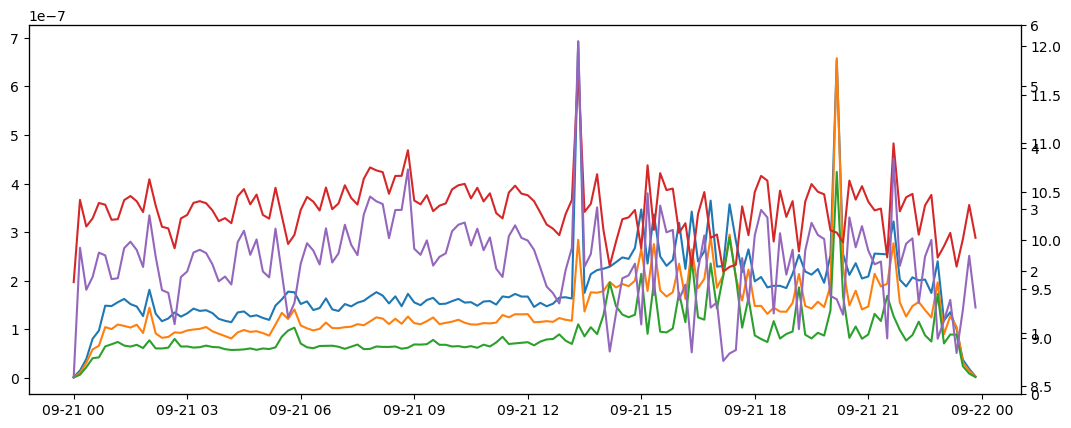

In [52]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
ax.plot(df['rsam'], label='RSAM')
ax.plot(df['mf'], label='MF')
ax.plot(df['hf'], label='HF')
ax.plot(np.nan, label='DSAR')

ax2 = ax.twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
ax2.set_ylim(0,6)

ax3 = ax.twinx()
ax3.plot(df['ndsar'], label='nDSAR', color='C4')

#ax.legend(ncol=4)

In [ ]:
# calculate frequencie bands AND save stream
jdays = ['{:03d}'.format(jday) for jday in range(1,366)]
#print(jdays)
st_long = obspy.Stream()
for i, jday in enumerate(jdays,1):
    st_dec = freq_bands_taper(jday)
    st_long += st_dec
    
    sys.stdout.write('\r{} of {}\n'.format(i, len(jdays)))
    sys.stdout.flush()

st_long.write("tmp_2005/st_2005.mseed", format="MSEED") # save stream
st_long

In [ ]:
# # to save a masked stream

# st_copy = st_long.copy() # copy original stream

# for tr in st_copy: # demask stream
#     if isinstance(tr.data, np.ma.masked_array):
#         tr.data = tr.data.filled(np.nan)

# #st_copy.write("tmp/st_2004.mseed", format="MSEED") # save stream copy (demasked)

## Read

In [ ]:
st_r = obspy.read('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/tmp_2005/st_2005.mseed')
st_r.detrend('demean')
#st_r.merge()
st_r.plot()
st_r

In [ ]:
st_long = st_r.copy()
st_long.merge()

In [564]:
all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/*.csv'))
# all_files = all_files[:]
all_files

['/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_001.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_002.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_003.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_004.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_005.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_006.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_007.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_008.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_009.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_010.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_011.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_012.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_013.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EDM_014.csv',
 '/dat

In [565]:
# all_files = sorted(glob.glob('../data/tmp_2004/EDM/_tmp_taper_*.csv'))
# all_files = all_files[242:275]
li = []
for filename in all_files:
    frame = pd.read_csv(filename)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df

rsam          mf          hf      dsar
time                                                             
2004-01-01 00:00:00   10.154557    6.297360    8.838843  1.771391
2004-01-01 00:10:00   11.367888    7.630036   10.780168  1.621281
2004-01-01 00:20:00   10.714017    7.637466   10.231238  1.614559
2004-01-01 00:30:00   10.909018    7.033759   12.038647  1.403196
2004-01-01 00:40:00   10.868660    7.320254   11.634683  1.362160
...                         ...         ...         ...       ...
2004-12-30 23:00:00  874.356248  422.550965  173.410078  4.356414
2004-12-30 23:10:00  690.481640  322.355887  137.965931  4.356549
2004-12-30 23:20:00  502.055149  226.858736   92.444505  4.469900
2004-12-30 23:30:00  299.042929  128.506692   56.394012  4.236239
2004-12-30 23:40:00   67.195903   32.461834   13.056195  4.423293

[50778 rows x 4 columns]

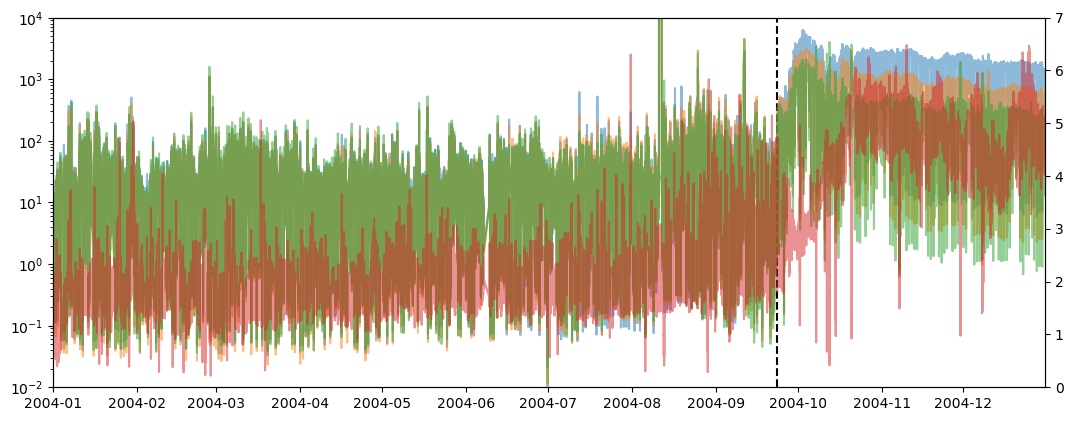

In [583]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))

ax.plot(df['rsam'], label='RSAM', alpha=0.5)
ax.plot(df['mf'], label='MF', alpha=0.5)
ax.plot(df['hf'], label='HF', alpha=0.5)
ax.plot(np.nan, label='DSAR')
# ax.set_ylim(0,8e3) # linear
ax.set_ylim(1e-2,1e4) # log
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3', alpha=0.5)
ax2.set_ylim(0,7)

ax.set_xlim(df.index[0], df.index[-1])
ax.vlines(UTCDateTime('2004-09-23T09:00:00'),ax.get_ylim()[0],ax.get_ylim()[-1], 'k','--')

#ax.legend(ncol=4)

In [584]:
df = pd.read_csv('../EDM_extended.csv')
df.head()

time       rsam        mf         hf      dsar  zsc2_rsam  \
0  2004-01-01 00:00:00  10.154557  6.297360   8.838843  1.771391   0.203439   
1  2004-01-01 00:10:00  11.367888  7.630036  10.780168  1.621281   0.203439   
2  2004-01-01 00:20:00  10.714017  7.637466  10.231238  1.614559   0.213968   
3  2004-01-01 00:30:00  10.909018  7.033759  12.038647  1.403196   0.213968   
4  2004-01-01 00:40:00  10.868660  7.320254  11.634683  1.362160   0.216872   

    zsc2_mf   zsc2_hf  zsc2_dsar  
0  0.153249  0.203132   0.147992  
1  0.153249  0.203132   0.147992  
2  0.186580  0.242551   0.144796  
3  0.171647  0.242551   0.069261  
4  0.171647  0.283455   0.059257

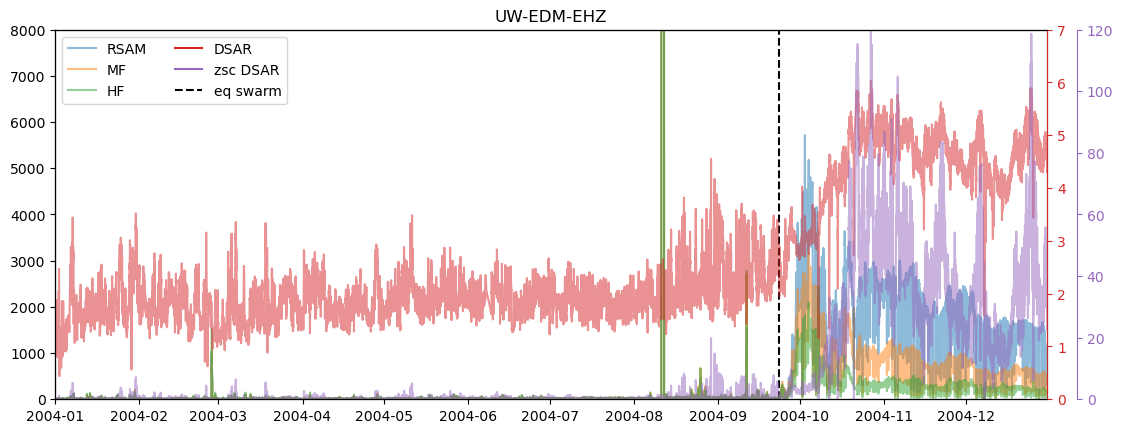

In [620]:
df = pd.read_csv('../EDM_extended.csv')
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df = df.rolling('1H', center=True).median()
# df = df.resample('1H').median()

fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))

ax.plot(df['rsam'], label='RSAM', alpha=0.5)
ax.plot(df['mf'], label='MF', alpha=0.5)
ax.plot(df['hf'], label='HF', alpha=0.5)
ax.plot(np.nan, label='DSAR')
ax.plot(np.nan, label='zsc DSAR')
ax.plot(np.nan, label='eq swarm', color='k',linestyle='--')
ax.set_ylim(0,8e3) # linear
# ax.set_ylim(1e-2,1e4) # log
# ax.set_yscale('log')

ax2 = ax.twinx()
ax2.spines.right.set_color('C3')
ax2.tick_params(axis='y', colors='C3')
ax2.tick_params(axis='y', colors='C3')
ax2.plot(df['dsar'], label='DSAR', color='C3', alpha=0.5)
ax2.set_ylim(0,7)

ax3 = ax.twinx()
ax3.spines.right.set_position(("axes", 1.03))
ax3.spines.right.set_color('C4')
ax3.tick_params(axis='y', colors='C4')
ax3.tick_params(axis='y', colors='C4')
ax3.plot(df['zsc2_dsar'], label='zscDSAR', color='C4', alpha=0.5)
ax3.set_ylim(0,120)

ax.set_xlim(df.index[0], df.index[-1])
ax.vlines(UTCDateTime('2004-09-23T09:00:00'),ax.get_ylim()[0],ax.get_ylim()[-1], 'k','--')

ax.set_title('UW-EDM-EHZ')
ax.legend(ncol=2, loc='upper left')

## Simple Plot

#### Rolling

In [102]:
df_roll = df.rolling('1H', center=True).median()
df_roll

rsam         mf         hf      dsar      ndsar
time                                                                      
2004-09-15 00:00:00    3.827629   2.054326   4.194917  1.196830   3.427769
2004-09-15 00:10:00    5.728252   3.208924   6.816224  1.209426   3.440365
2004-09-15 00:20:00    6.670033   3.488959   7.627559  1.283519   3.514458
2004-09-15 00:30:00    9.827374   4.597138   9.349660  1.270923   3.501862
2004-09-15 00:40:00   11.928046   5.513641  10.463916  1.263283   3.494221
...                         ...        ...        ...       ...        ...
2004-10-16 23:10:00  472.598931  79.529918  40.414437  4.152639  13.691684
2004-10-16 23:20:00  272.016612  43.509918  24.383593  4.243725  13.782770
2004-10-16 23:30:00  165.792237  28.345130  16.024471  4.153473  13.692518
2004-10-16 23:40:00  109.164939  18.224998  10.280719  4.152639  13.691684
2004-10-16 23:50:00   52.537640   8.104866   4.536966  4.153473  13.692518

[4604 rows x 5 columns]

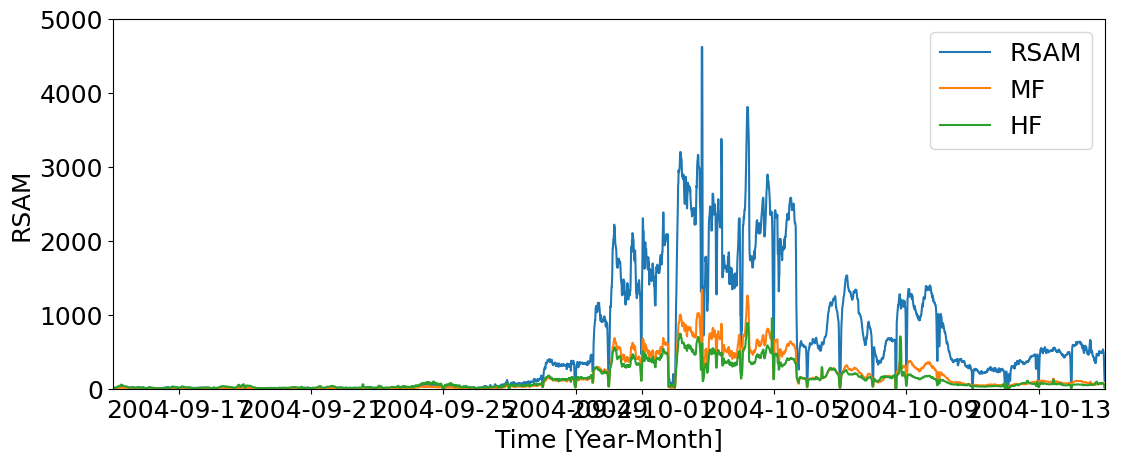

In [103]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))

# ax.plot(df_roll['rsam'], label='RSAM')
# ax.plot(df_roll['mf'], label='MF')
# ax.plot(df_roll['hf'], label='HF')
ax.plot(df_roll['dsar'], label='DSAR','k')

# ax.plot(np.nan, label='DSAR')
# ax.plot(np.nan, label='nDSAR')

# ax2 = ax.twinx()
# ax2.plot(df_roll['dsar'], label='DSAR', color='C3')
# ax3 = ax.twinx()
# ax3.plot(df_roll['ndsar'], label='nDSAR', color='C4')

ax.set_xlabel('Time [Year-Month]')
ax.set_ylim(0,5e3)
ax.set_ylabel('RSAM')
# ax2.set_ylim(0,5)
# ax2.set_ylabel('DSAR')
# ax3.set_ylim(0,50)
# ax3.set_ylabel('nDSAR')
# ax3.spines.right.set_position(("axes", 1.07))

# for idx in df_activity.index[:15]:
#     ax.axvline(idx, color='black', linewidth=1)
ax.set_xlim(datetime.datetime(2004,9,15),datetime.datetime(2004,10,15))


ax.legend(ncol=1)
#fig.savefig('../plots/2004_taper_roll1.png', bbox_inches='tight', dpi=300)

### Resampling

In [114]:
df_res = df.resample('0.5H').mean()
df_res

rsam           mf          hf      dsar      ndsar
time                                                                          
2004-09-15 00:00:00     8.668741     8.799133    7.287460  2.100800   7.877215
2004-09-15 00:30:00    37.034385    29.801466   20.603192  2.721620   8.498035
2004-09-15 01:00:00    54.989358    39.204988   25.608383  2.849310   8.625725
2004-09-15 01:30:00    50.952859    47.677690   43.138641  2.037628   7.814043
2004-09-15 02:00:00    73.124095    64.000181   53.545776  2.217282   7.993696
...                          ...          ...         ...       ...        ...
2004-10-16 21:30:00  2284.770674  1195.354839  454.613161  4.443485  20.402673
2004-10-16 22:00:00  2315.941542  1260.996460  467.474887  4.526176  20.485363
2004-10-16 22:30:00  2214.366453  1230.221687  455.989816  4.544750  20.503937
2004-10-16 23:00:00  2533.990954  1409.891666  508.747043  4.653906  20.613093
2004-10-16 23:30:00  1090.953684   638.411140  226.024779  4.674403  20.633591

[1536 rows x 5 columns]

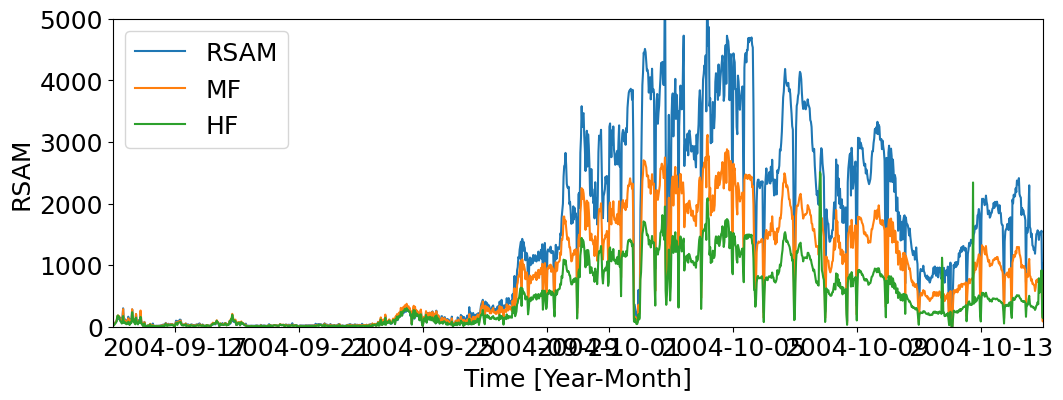

In [115]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,1, sharex=True, figsize=(12, 4))

ax.plot(df_res['rsam'], label='RSAM')
ax.plot(df_res['mf'], label='MF')
ax.plot(df_res['hf'], label='HF')
# ax.plot(np.nan, label='DSAR')
# ax.plot(np.nan, label='nDSAR')

# ax2 = ax.twinx()
# ax2.plot(df_res['dsar'], label='DSAR', color='C3')
# ax3 = ax.twinx()
# ax3.plot(df_res['ndsar'], label='nDSAR', color='C4')

ax.set_xlabel('Time [Year-Month]')
ax.set_ylim(0,5e3)
ax.set_ylabel('RSAM')
# ax2.set_ylim(0,5)
# ax2.set_ylabel('DSAR')
# ax3.set_ylim(0,50)
# ax3.set_ylabel('nDSAR')
ax3.spines.right.set_position(("axes", 1.07))

#ax.axvline(df_activity.index[0], color='black', linewidth=3, label='Eruption')
# for idx in df_activity.index[:15]:
#     ax.axvline(idx, color='black', linewidth=1)
ax.set_xlim(datetime.datetime(2004,9,15),datetime.datetime(2004,10,15))
#ax.set_ylim(-5e10,1.4e12)
#ax2.set_ylim(1,5.5)
# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 6))

ax.legend(ncol=1, loc='upper left')
#fig.savefig('../plots/2004_sep_taper_res8.png', bbox_inches='tight', dpi=300)

In [ ]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
ax.plot(df_roll['rsam'], label='RSAM')
ax.plot(df_roll['mf'], label='MF')
ax.plot(df_roll['hf'], label='HF')
ax.plot(np.nan, label='DSAR')

ax2 = ax.twinx()
ax2.plot(df_roll['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax.legend(ncol=4)

In [ ]:
np.arange(start, end, 6)

In [ ]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,1, sharex=True, figsize=(16, 4))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
ax.plot(df_res['rsam'], label='RSAM')
ax.plot(df_res['mf'], label='MF')
ax.plot(df_res['hf'], label='HF')
ax.plot(np.nan, label='DSAR')

ax2 = ax.twinx()
ax2.plot(df_res['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
plt.xticks(rotation=45)
ax.set_xlabel('Time [Year-Month]')
ax.set_ylabel('RSAM')
ax2.set_ylabel('DSAR')

ax.axvline(datetime.datetime(2004, 9, 23), color='black', linewidth=3, label='Eruption')
ax.legend(ncol=2)
#fig.savefig('../plots/2004_taper_res2.png', bbox_inches='tight', dpi=300)

### Trim

In [68]:
st

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-21T00:00:00.009900Z - 2004-09-22T00:00:00.009900Z | 100.0 Hz, 8640001 samples

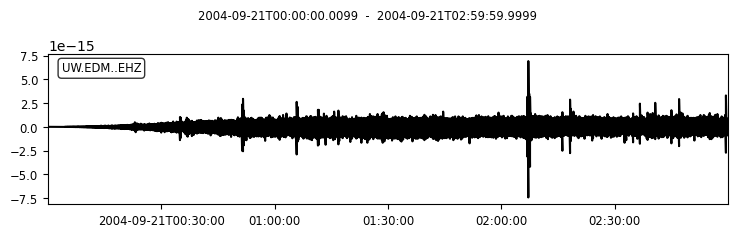

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-21T00:00:00.009900Z - 2004-09-21T02:59:59.999900Z | 100.0 Hz, 1080000 samples

In [69]:
# trim stream
start_trim = obspy.UTCDateTime(2004,9,21)
end_trim = obspy.UTCDateTime(2004,9,21,3)
st_trim = st.copy()
st_trim.trim(start_trim, end_trim)
st_trim.plot()
st_trim.merge()
st_trim

In [ ]:
# trim
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(st_trim[0].times('matplotlib'), st_trim[0].data, color='k', 
           label='{}.{}..{}'.format(st_trim[0].stats['network'],
                                    st_trim[0].stats['station'],
                                    st_trim[0].stats['channel']))
ax[1].plot(df['rsam'], label='LF')
ax[1].plot(df['mf'], label='MF')
ax[1].plot(df['hf'], label='HF')
ax[1].plot(np.nan, label='DSAR')

ax2 = ax[1].twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax[1].set_xlim(start_trim.datetime, end_trim.datetime)

ax[1].set_ylabel('RSAM')
ax2.set_ylabel('DSAR')
ax[0].legend(loc='upper left')
ax[1].legend(ncol=4, loc='upper left')

fig.savefig('plots/2005_EDM_2m_1.png', bbox_inches='tight', dpi=300)

### Plot with stream

In [ ]:
    fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
    ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
               label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
    #ax[0].set_ylim(-4000,4000)
    ax[1].plot(df['rsam'], label='RSAM')
    ax[1].plot(df['mf'], label='MF')
    ax[1].plot(df['hf'], label='HF')
    ax[1].plot(np.nan, label='DSAR')

    ax2 = ax[1].twinx()
    ax2.plot(df['dsar'], label='DSAR', color='C3')
    #ax2.set_ylim(0,2.5)

    ax[0].legend(loc='upper left')
    ax[1].legend(ncol=4, loc='upper left')
    fig.savefig('plots/2005_EDM_1y_taper.png', bbox_inches='tight', dpi=300)

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k')
#ax[0].set_ylim(-4000,4000)
ax[1].plot(df['rsam'], label='RSAM')
ax[1].plot(df['mf'], label='MF')
ax[1].plot(df['hf'], label='HF')
ax[1].plot(np.nan, label='DSAR')

ax2 = ax[1].twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax[1].legend(ncol=4)

## Multi-year plot

In [ ]:
years = range(2004,2011)
sta = 'EDM'
fig, ax = plt.subplots(len(years),1, figsize=(6.4*2, 4.8/2*len(years)))
for i, year in enumerate(years):
    
    # load RSA and DSAR
    all_files = sorted(glob.glob('tmp_{}/{}/_tmp_taper_*.csv'.format(year,sta)))
    #all_files = all_files[1:]
    li = []
    for filename in all_files:
        frame = pd.read_csv(filename)
        li.append(frame)

    df = pd.concat(li, axis=0, ignore_index=True)
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    
    # plot
    ax[i].plot(df['rsam'], label='RSAM', alpha=0.8)
    ax[i].plot(df['mf'], label='MF', alpha=0.8)
    ax[i].plot(df['hf'], label='HF', alpha=0.8)
    ax[i].plot(np.nan, label='DSAR', alpha=0.8)
    ax[i].set_ylabel('RSAM')
    ax[i].set_ylim(0,1e12)
#     ax[i].set_ylim(1e7,1e13)
#     ax[i].set_yscale('log')

    ax2 = ax[i].twinx()
    ax2.plot(df['dsar'], color='C3', alpha=0.8)
    ax2.set_ylabel('DSAR')
    ax2.set_ylim(0,10)
#     ax2.set_ylim(1e-1,10)
#     ax2.set_yscale('log')

    # plot vertical lines where volcano activityes were recordet
    for index,row in df_activity.iterrows():
        if index.year == year: # plot only one year per subplot
            index=str(index)
            if len(row[0])==1: # plot all start times as solid line
                ax[i].axvline(datetime.datetime.strptime(index,"%Y-%m-%d %H:%M:%S"), linestyle='-', color='k')
            if len(row[0])>1: # plot all end times as dotted line
                ax[i].axvline(datetime.datetime.strptime(index,"%Y-%m-%d %H:%M:%S"), linestyle=':', color='k')
                
                
ax[0].legend(loc='upper left', ncol=4)
fig.savefig('plots/{}_{}_{}_taper2.png'.format(years[0],years[-1],sta), bbox_inches='tight', dpi=300)

In [ ]:
std_rsam = np.std(df['rsam'])
std_mf = np.std(df['mf'])
std_hf = np.std(df['hf'])
std_dsar = np.std(df['dsar'])

mean_rsam = np.mean(df['rsam'])
mean_mf = np.mean(df['mf'])
mean_hf = np.mean(df['hf'])
mean_dsar = np.mean(df['dsar'])

In [ ]:
df

In [ ]:
# diese df entält nur werte die ALLE im threshold liegen
factor = 10
#df2 = df[ ( df['rsam'] < mean_rsam+factor*std_rsam) & (df['rsam'] > mean_rsam-factor*std_rsam)]
df2 = df[ ( df['rsam'] < 8e9) & (df['rsam'] > 7e9) & #rsam 7.
         ( df['mf'] < 7e9) & (df['mf'] > 6e9) ] #mf 6.
df2

In [ ]:
df_test = df.copy()
idx_rsam = ( df['rsam'] < 8e9) & (df['rsam'] > 7e9)
df_test['rsam'][~idx_rsam] = np.nan
#df_test

In [ ]:
df_roll_mean = df_roll.resample('1H').median()

In [15]:
def noise_analysis(data, datas, samp_rate, N, Nm):
    rms_list = []
    rmes_list = []
    pgv_list = []
    pga_list = []

    for i in np.arange(0,Nm,N): # start samples (sample, where next 10min starts)
        data_cut = data[i:i+N-1]

        rms = np.sqrt(np.mean(data_cut**2))
        rmes = np.sqrt(np.median(data_cut**2))
        pgv = max(abs(data_cut))

        data_acc = (data_cut.copy()[:-1] - data_cut.copy()[1:]) / (1/samp_rate)
        pga = max(abs(data_acc))

        rms_list.append(rms)
        rmes_list.append(rmes)
        pgv_list.append(pgv)
        pga_list.append(pga)
    datas.append(np.array(rms_list))
    datas.append(np.array(rmes_list))
    datas.append(np.array(pgv_list))
    datas.append(np.array(pga_list))
    return (datas)

In [16]:
def create_df(datas, ti, freqs_names, df):
    datas = np.array(datas)
    time = [(ti+j*600).datetime for j in range(datas.shape[1])]
    df_tr = pd.DataFrame(zip(*datas), columns=freqs_names+['rms','rmes','pgv','pga'], index=pd.Series(time))
    df = pd.concat([df, df_tr])
    return(df) 

In [39]:
import numpy as np
import pandas as pd
import obspy
import obspy.signal.filter
import datetime
import scipy
import glob
import sys
import os
import scipy as sc
import time
import matplotlib.pyplot as plt
import argparse
import warnings
warnings.filterwarnings("ignore")

import multiprocessing
from functools import partial

sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()

# Define all functions---------------------------------------------------

def preprocessing(year,jday, net, sta, cha):

    try:
        # this stream will be used for RSAM and DSAR calculations
        #st = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st = client.get_waveforms(network=net, station=sta, channel=cha,
                                       year='{}'.format(year), doy='{}'.format(jday))

        st.detrend('linear')
        st.taper(max_percentage=None,max_length=5, type='hann') #max_length in sec
        
        # correct insrument response
        inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
        pre_filt = [1e-3, 5e-2, 45, 50]
        water_level = 60
        
        for tr in st:
            tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                                      pre_filt=pre_filt, output="VEL", water_level=water_level,
                                      plot=False)

            # correct positive dip
            dip = inv.get_orientation(tr.id, datetime=tr.stats.starttime)['dip']
            if dip > 0:
                tr.data *= -1
#         st.merge(fill_value=0)
        print(':) year={}, jday={}, net={}, sta={}, cha={}'.format(year,jday, net, sta, cha))
    except:
        print('pass station {} day {}'.format(sta,jday))
    return(st)
    
def noise_analysis(data, datas, samp_rate, N, Nm):
    rms_list = []
    rmes_list = []
    pgv_list = []
    pga_list = []

    for i in np.arange(0,Nm,N): # start samples (sample, where next 10min starts)
        data_cut = data[i:i+N-1]

        rms = np.sqrt(np.mean(data_cut**2))
        rmes = np.sqrt(np.median(data_cut**2))
        pgv = max(abs(data_cut))

        data_acc = (data_cut.copy()[:-1] - data_cut.copy()[1:]) / (1/samp_rate)
        pga = max(abs(data_acc))

        rms_list.append(rms)
        rmes_list.append(rmes)
        pgv_list.append(pgv)
        pga_list.append(pga)
    datas.append(np.array(rms_list))
    datas.append(np.array(rmes_list))
    datas.append(np.array(pgv_list))
    datas.append(np.array(pga_list))
    return (datas)
    
def RSAM(data, samp_rate, datas, freq, Nm, N):
    filtered_data = obspy.signal.filter.bandpass(data, freq[0], freq[1], samp_rate)
    filtered_data = abs(filtered_data[:Nm])
    datas.append(filtered_data.reshape(-1,N).mean(axis=-1)*1.e9)
    return(datas)

def VSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute ratio between different velocities
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('hf')
    hfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    hfd = abs(hfd[:Nm])
    hfd = hfd.reshape(-1,N).mean(axis=-1)
    vsar = mfd/hfd
    datas.append(vsar)
    return(datas)

def DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute dsar
    data = scipy.integrate.cumtrapz(data, dx=1./100, initial=0) # vel to disp
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('hf')
    hfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    hfd = abs(hfd[:Nm])
    hfd = hfd.reshape(-1,N).mean(axis=-1)
    dsar = mfd/hfd
    datas.append(dsar)
    return(datas)

def lDSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute dsar for low frequencies
    data = scipy.integrate.cumtrapz(data, dx=1./100, initial=0) # vel to disp
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('rsam')
    lfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    lfd = abs(lfd[:Nm])
    lfd = lfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    ldsar = lfd/mfd
    datas.append(ldsar)
    return(datas)

def nDSAR(datas):
    dsar = datas[3]
    ndsar = dsar/sc.stats.zscore(dsar)
    datas.append(ndsar)
    return(datas)
    
# creates a df for each trace and append this df to a daily df
# def create_df(datas, ti, freqs_names, df):
#     datas = np.array(datas)
#     time = [(ti+j*600).datetime for j in range(datas.shape[1])]
#     df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
#     df = pd.concat([df, df_tr])
#     return(df)    

def create_df(datas, ti, freqs_names, df):
    datas = np.array(datas)
    time = [(ti+j*600).datetime for j in range(datas.shape[1])]
    df_tr = pd.DataFrame(zip(*datas), columns=freqs_names+['rms','rmes','pgv','pga'], index=pd.Series(time))
    df = pd.concat([df, df_tr])
    return(df) 
    
# main function..............................................................................
def freq_bands_taper(jday, year, net, sta, cha):   
    ''' 
    calculate and store power in 10 min long time windows for different frequency bands
    sensor measured ground velocity
    freqs: list contains min and max frequency in Hz
    dsar: float represents displacement (integration of)'''
    
    start_time = time.time()
    freqs_names = ['rsam','mf','hf','dsar','ldsar', 'vsar']
    df = pd.DataFrame(columns=freqs_names)
    daysec = 24*3600
    freqs = [[2,5], [4.5,8], [8,16]]
    
    st = preprocessing(year,jday, net, sta, cha)

    if len(st)>0: # if stream not empty
#         st.resample(50)
        for tr in st:
#         tr = st[0]
            datas = []
            data = tr.data
            samp_rate = tr.meta['sampling_rate']
            ti = tr.meta['starttime']
            # round start time to nearest 10 min increment
            tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
            ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
            N = int(600*samp_rate)    # 10 minute windows in seconds
            Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
            # seconds per day (86400) * sampling rate (100) -> datapoints per day

            for freq, frequ_name in zip(freqs, freqs_names[:3]):
                datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

            datas = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
            datas = lDSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
            datas = VSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
#             datas = nDSAR(datas) # --> add ndsar in freqs_names

            datas = noise_analysis(data, datas, samp_rate, N, Nm)

            df = create_df(datas, ti, freqs_names, df)
        
        if not os.path.exists('../tmp_{}/{}'.format(year, sta)):
            os.makedirs('../tmp_{}/{}'.format(year, sta))
        df.to_csv('../tmp_{}/{}/{}_{}.csv'.format(year,sta,sta,jday), index=True, index_label='time')
        print('One day tooks {} seconds.'.format(round(time.time()-start_time),3))
    return()



year = 2004
jdays = 1
net = 'UW'
sta = 'EDM'
cha = 'EHZ'
# for sta in ['EDM','SHW','HSR','SOS','TDL','ELK','FL2','CDF','JUN','YEL','SEP','STD']:
stime = time.time()
freq_bands_taper(year=year, net=net, sta=sta, cha=cha, jday=jday)
print('Calculation tooks {} seconds.'.format(round(time.time()-stime),3))


:) year=2004, jday=265, net=UW, sta=EDM, cha=EHZ
One day tooks 10 seconds.
Calculation tooks 10 seconds.


[array([ 0.09731615,  1.37773211,  4.94015355, 11.38098863, 13.87352073,
        21.14323103, 21.06468565, 22.18566749, 23.07606388, 21.54966321,
        20.89326386, 18.07716153, 25.70741176, 18.7279421 , 16.60683818,
        17.40046375, 19.16910501, 17.88304572, 18.86207929, 20.26815224,
        19.57648061, 19.74832236, 18.93480516, 17.27923311, 16.74385257,
        16.31287036, 19.13034628, 19.43736705, 17.97337654, 18.28764419,
        17.50683387, 16.92780895, 21.05920962, 22.917657  , 25.19423099,
        24.92685644, 21.57230654, 22.32341518, 19.79761153, 20.40339472,
        23.14746716, 19.98496277, 19.53416312, 21.55211944, 20.89591751,
        21.93968694, 22.55885958, 23.87658029, 25.01025962, 23.99813788,
        21.76033489, 23.77381533, 20.939793  , 24.50607686, 22.04873911,
        21.1906869 , 22.69587364, 23.32999796, 21.54855659, 21.64355912,
        22.3865985 , 23.02956411, 21.94502966, 22.10235477, 21.04220481,
        22.27884976, 22.4130819 , 21.38986771, 23.7

In [34]:
datas_copy = datas.copy()
print(len(datas_copy))
datas_copy = noise_analysis(data, datas_copy, samp_rate, N, Nm)
print(len(datas_copy))

4
8


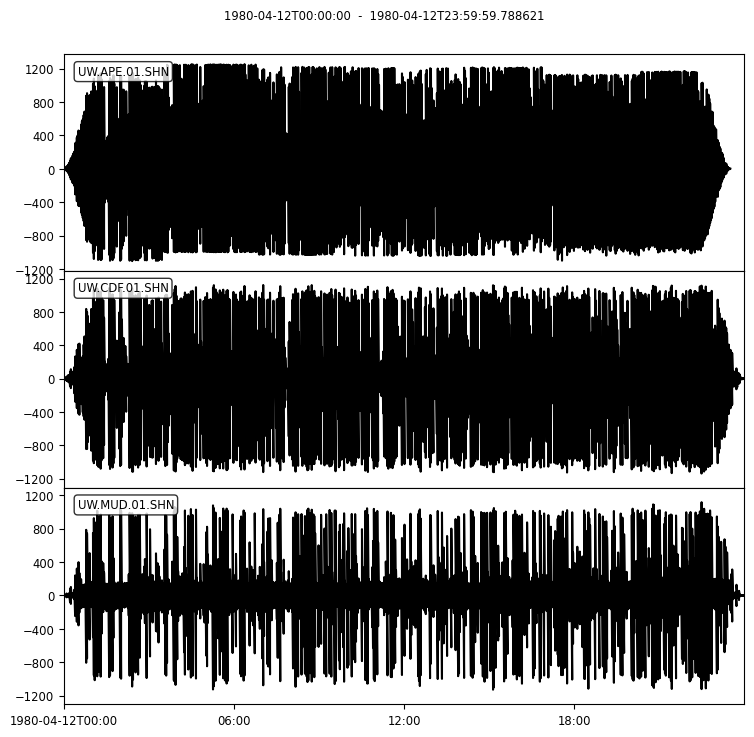

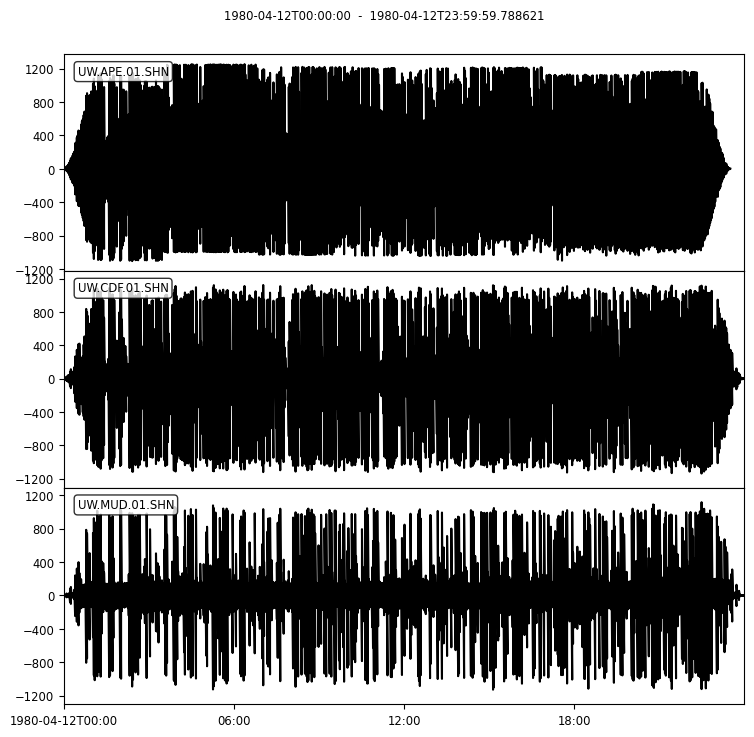

In [32]:
import obspy
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime

client = Client("IRIS")
t1 = UTCDateTime("1980-04-12T00:00:00.000")
t2 = UTCDateTime("1980-04-13T00:00:00.000")
st = client.get_waveforms("UW", None, None, 'SHN', t1, t2)

# st = client.get_waveforms(network='UW', station=sta, channel=cha,
#                                year='{}'.format(year), doy='{}'.format(jday))
#
st.detrend('linear')
st.taper(0.05, type='hann')

# # correct insrument response
# inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
# pre_filt = [1e-3, 5e-2, 45, 50]
# water_level = 60

# for tr in st:
#     tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
#                               pre_filt=pre_filt, output="VEL", water_level=water_level,
#                               plot=False)

st.plot()

In [15]:
def preprocessing(year,jday, net, sta, cha):

    try:
        # this stream will be used for RSAM and DSAR calculations
        #st = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st = client.get_waveforms(network=net, station=sta, channel=cha,
                                       year='{}'.format(year), doy='{}'.format(jday))

        st.detrend('linear')
        st.taper(0.05, type='hann')
        
        # correct insrument response
        inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
        pre_filt = [1e-3, 5e-2, 45, 50]
        water_level = 60

        for tr in st:
            tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                                      pre_filt=pre_filt, output="VEL", water_level=water_level,
                                      plot=False)

            # correct positive dip
            dip = inv.get_orientation(tr.id, datetime=tr.stats.starttime)['dip']
            if dip > 0:
                tr.data *= -1
#         st.merge(fill_value=0)
        print(':) year={}, jday={}, net={}, sta={}, cha={}'.format(year,jday, net, sta, cha))
    except:
        print('pass station {} day {}'.format(sta,jday))
    return(st)
    
def RSAM(data, samp_rate, datas, freq, Nm, N):
    filtered_data = obspy.signal.filter.bandpass(data, freq[0], freq[1], samp_rate)
    filtered_data = abs(filtered_data[:Nm])
    datas.append(filtered_data.reshape(-1,N).mean(axis=-1)*1.e9)
    return(datas)
    
def DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute dsar
    data = scipy.integrate.cumtrapz(data, dx=1./100, initial=0) # vel to disp
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('hf')
    hfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    hfd = abs(hfd[:Nm])
    hfd = hfd.reshape(-1,N).mean(axis=-1)
    dsar = mfd/hfd
    datas.append(dsar)
    return(datas)

def nDSAR(datas):
    dsar = datas[3] # must contain more than one data point
    ndsar = dsar/sc.stats.zscore(dsar)
    datas.append(ndsar)
    return(datas)
    
# creates a df for each trace and append this df to a daily df
def create_df(datas, ti, freqs_names, df):
    datas = np.array(datas)
    time = [(ti+j*600).datetime for j in range(datas.shape[1])]
    df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
    df = pd.concat([df, df_tr])
    return(df)  

year = 2005
jday = 117#119
net = 'UW'
sta = 'SHW'
cha = 'EHZ'

freqs_names = ['rsam','mf','hf','dsar','ndsar']
df = pd.DataFrame(columns=freqs_names)
daysec = 24*3600
freqs = [[2,5], [4.5,8], [8,16]]

st = preprocessing(year,jday, net, sta, cha)

if len(st)>0: # if stream not empty 
    # merge the traces if the data gap is smaller than 1 minute otherwise add trace separate
    st_n = obspy.Stream()
    for i in range(1,len(st)): # i is the trace index
        t_diff = st[i].stats.starttime-st[i-1].stats.endtime
#         print(t_diff)
        if i == 1:
            tr_n = st[i-1] # first trace in stream
            
        elif i == len(st)-1: # last trace in stream
#             print(tr_n)
            st_n += tr_n
            
        elif t_diff <= 60: # missing data for more than 60 sec
            tr_n = tr_n.__add__(st[i-1],fill_value='interpolate')
            
        elif t_diff > 60:
#             print(tr_n)
            st_n += tr_n
            tr_n = st[i-1]
#     st_n = st        
    for tr in st_n:
        datas = []
        data = tr.data
        samp_rate = tr.meta['sampling_rate']
        ti = tr.meta['starttime']
        # round start time to nearest 10 min increment
        tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
        ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
        N = int(600*samp_rate)    # 10 minute windows in seconds
        Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
        # seconds per day (86400) * sampling rate (100) -> datapoints per day

        for freq, frequ_name in zip(freqs, freqs_names[:3]):
            datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

        datas = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
        datas = nDSAR(datas)
        df = create_df(datas, ti, freqs_names, df)
        if not os.path.exists('../tmp_{}/{}'.format(year, sta)):
            os.makedirs('../tmp_{}/{}'.format(year, sta))
        df.to_csv('../tmp_{}/{}/{}_{}.csv'.format(year,sta,sta,jday), index=True, index_label='time')
    print(df.shape)
df

:) year=2005, jday=117, net=UW, sta=SHW, cha=EHZ
(20, 5)


rsam         mf         hf      dsar      ndsar
2005-04-27 00:00:00  108.657207  23.965011  18.038703  2.742324  -5.056218
2005-04-27 00:10:00  240.378600  47.539191  30.580095  3.522663   3.076525
2005-04-27 00:20:00  208.621105  43.031275  33.578260  2.978823 -96.185866
2005-04-27 00:30:00  282.099436  45.674958  36.486142  2.934412 -23.105518
2005-04-27 00:40:00  265.970672  45.504947  33.541284  3.151201   9.220064
2005-04-27 00:50:00  138.675533  36.573977  42.118180  2.107705  -1.100833
2005-04-27 01:00:00  332.956346  55.595615  39.520583  3.347136   4.372710
2005-04-27 01:10:00  248.250783  32.166198  34.645278  2.368119  -1.752171
2005-04-27 01:20:00  214.036991  31.205379  35.000538  2.139708  -1.159454
2005-04-27 01:30:00  246.279611  36.904361  29.505580  2.896291 -13.829182
2005-04-27 01:40:00  144.962518  36.808036  28.157921  2.973891 -71.431882
2005-04-27 01:50:00  215.108418  40.581890  27.202576  3.539909   2.994074
2005-04-27 02:00:00  266.113265  42.745982  31.123203  3.333533   4.528977
2005-04-27 02:10:00  227.183883  43.805391  29.779661  3.420753   3.699528
2005-04-27 02:20:00  100.990168  21.737026  13.720017  3.440701   3.555249
2005-04-27 05:30:00   13.294994   5.165672   3.395316  1.824601        NaN
2005-04-27 06:00:00   33.942193  11.356664   6.013464  1.840283        NaN
2005-04-27 08:20:00   14.434180   4.422846   2.620544  1.822295        NaN
2005-04-27 16:00:00   25.955486   9.613832   8.008591  1.827071        NaN
2005-04-27 18:10:00   34.156788  11.143972   7.818630  1.902792        NaN

In [487]:
df_h = df.resample('10min').mean()
df_h

rsam         mf         hf      dsar      ndsar
2005-04-27 00:00:00  108.656871  23.964857  18.038618  3.267967   5.637145
2005-04-27 00:10:00  240.378600  47.539191  30.580095  3.522663   3.122613
2005-04-27 00:20:00  208.621105  43.031275  33.578260  2.978823 -69.522877
2005-04-27 00:30:00  282.099436  45.674958  36.486142  2.934412 -21.192055
2005-04-27 00:40:00  265.970672  45.504947  33.541284  3.151201   9.598327
2005-04-27 00:50:00  138.675533  36.573977  42.118180  2.107705  -1.098634
2005-04-27 01:00:00  332.956346  55.595615  39.520583  3.347136   4.461768
2005-04-27 01:10:00  248.250783  32.166198  34.645278  2.368119  -1.744122
2005-04-27 01:20:00  214.036991  31.205379  35.000538  2.139708  -1.156866
2005-04-27 01:30:00  246.279611  36.904361  29.505580  2.896291 -13.132231
2005-04-27 01:40:00  144.962518  36.808036  28.157921  2.973891 -55.623956
2005-04-27 01:50:00  215.108418  40.581890  27.202576  3.539909   3.037907
2005-04-27 02:00:00  266.113265  42.745982  31.123203  3.333533   4.624175
2005-04-27 02:10:00  227.183883  43.805391  29.779661  3.420753   3.764500

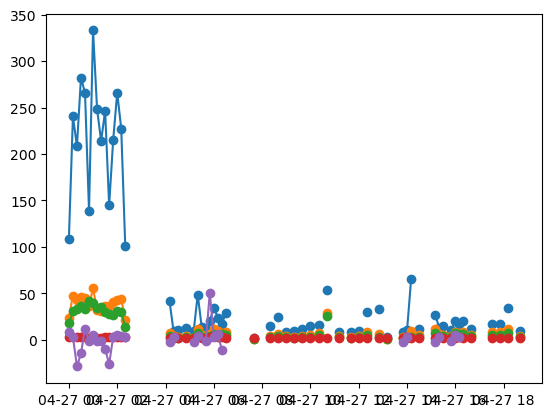

In [485]:
plt.plot(df.resample('10min').mean(), linestyle='-', marker='o')

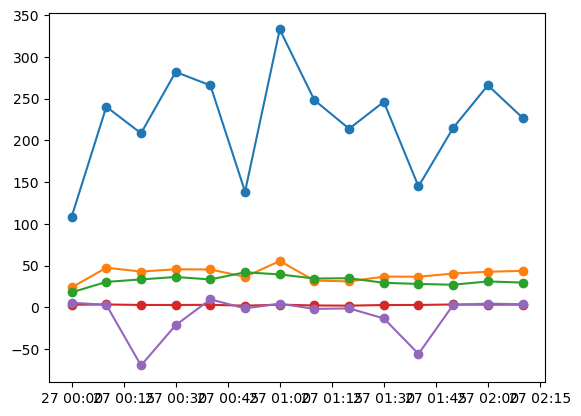

In [477]:
plt.plot(df.resample('10min').mean(), linestyle='-', marker='o')

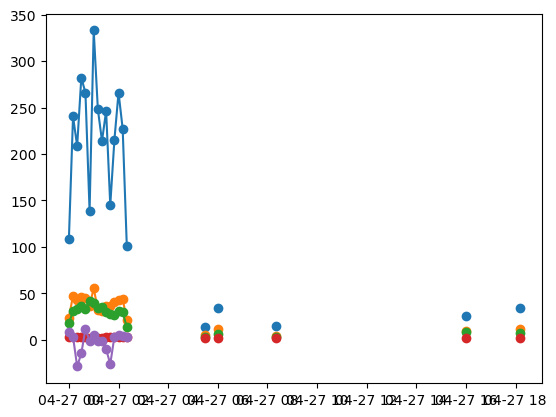

In [471]:
plt.plot(df.resample('10min').mean(), linestyle='-', marker='o')

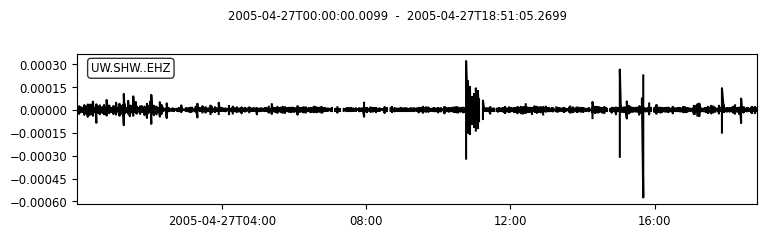

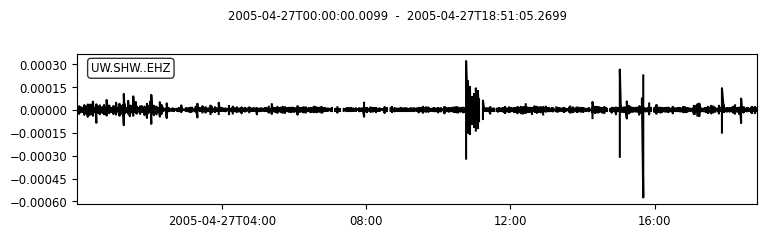

In [467]:
st_n.plot()

In [427]:
df

rsam         mf         hf      dsar      ndsar
2005-04-27 00:00:00  108.656871  23.964857  18.038618  3.204547   8.347883
2005-04-27 00:10:00  240.378600  47.539191  30.580095  3.522663   3.288658
2005-04-27 00:20:00  208.621105  43.031275  33.578260  2.978823 -28.699068
2005-04-27 00:30:00  282.099436  45.674958  36.486142  2.934412 -14.691025
2005-04-27 00:40:00  265.970672  45.504947  33.541284  3.151201  11.730919
2005-04-27 00:50:00  138.675533  36.573977  42.118180  2.107705  -1.061379
2005-04-27 01:00:00  332.956346  55.595615  39.520583  3.347136   4.837354
2005-04-27 01:10:00  248.250783  32.166198  34.645278  2.368119  -1.663939
2005-04-27 01:20:00  214.036991  31.205379  35.000538  2.139708  -1.116363
2005-04-27 01:30:00  246.279611  36.904361  29.505580  2.896291 -10.266813
2005-04-27 01:40:00  144.962518  36.808036  28.157921  2.973891 -25.984460
2005-04-27 01:50:00  215.108418  40.581890  27.202576  3.539909   3.193670
2005-04-27 02:00:00  266.113265  42.745982  31.123203  3.333533   5.031396
2005-04-27 02:10:00  227.183883  43.805391  29.779661  3.420753   4.019776
2005-04-27 02:20:00  100.730302  21.652697  13.543843  3.484290   3.525710
2005-04-27 05:30:00   13.282025   5.168726   3.398768  1.824627        NaN
2005-04-27 06:00:00   34.014748  11.518315   6.117152  1.838052        NaN
2005-04-27 08:20:00   14.656933   4.553438   2.686720  1.822310        NaN
2005-04-27 16:00:00   25.728079   9.511697   7.943067  1.826576        NaN
2005-04-27 18:10:00   33.864518  11.214385   7.779270  1.852270        NaN

In [412]:
st_n.print_gaps()

Source            Last Sample                 Next Sample                 Delta           Samples 
UW.SHW..EHZ       2005-04-27T02:31:53.129900Z 2005-04-27T02:32:08.149900Z 15.010000       1501    
UW.SHW..EHZ       2005-04-27T02:32:11.129900Z 2005-04-27T02:35:38.139900Z 207.000000      20700   
UW.SHW..EHZ       2005-04-27T02:38:19.129900Z 2005-04-27T02:39:00.149900Z 41.010000       4101    
UW.SHW..EHZ       2005-04-27T02:40:05.129900Z 2005-04-27T02:40:15.149900Z 10.010000       1001    
UW.SHW..EHZ       2005-04-27T02:44:59.129900Z 2005-04-27T02:45:38.149900Z 39.010000       3901    
UW.SHW..EHZ       2005-04-27T02:49:21.129900Z 2005-04-27T02:49:50.149900Z 29.010000       2901    
UW.SHW..EHZ       2005-04-27T02:53:13.129900Z 2005-04-27T02:53:15.149900Z 2.010000        201     
UW.SHW..EHZ       2005-04-27T03:01:39.129900Z 2005-04-27T03:01:54.155900Z 15.016000       1502    
UW.SHW..EHZ       2005-04-27T03:05:09.145900Z 2005-04-27T03:05:13.161200Z 4.005300        401     
UW.SHW..EH

In [530]:
print(st_n.__str__(extended=True))

297 Trace(s) in Stream:
UW.SHW..EHZ | 2005-04-27T00:00:00.009900Z - 2005-04-27T02:31:53.129900Z | 100.0 Hz, 911313 samples
UW.SHW..EHZ | 2005-04-27T02:32:08.149900Z - 2005-04-27T02:32:11.129900Z | 100.0 Hz, 299 samples
UW.SHW..EHZ | 2005-04-27T02:35:38.139900Z - 2005-04-27T02:38:19.129900Z | 100.0 Hz, 16100 samples
UW.SHW..EHZ | 2005-04-27T02:39:00.149900Z - 2005-04-27T02:40:05.129900Z | 100.0 Hz, 6499 samples
UW.SHW..EHZ | 2005-04-27T02:40:15.149900Z - 2005-04-27T02:44:59.129900Z | 100.0 Hz, 28399 samples
UW.SHW..EHZ | 2005-04-27T02:45:38.149900Z - 2005-04-27T02:49:21.129900Z | 100.0 Hz, 22299 samples
UW.SHW..EHZ | 2005-04-27T02:49:50.149900Z - 2005-04-27T02:53:13.129900Z | 100.0 Hz, 20299 samples
UW.SHW..EHZ | 2005-04-27T02:53:15.149900Z - 2005-04-27T03:01:39.129900Z | 100.0 Hz, 50399 samples
UW.SHW..EHZ | 2005-04-27T03:01:54.155900Z - 2005-04-27T03:05:09.145900Z | 100.0 Hz, 19500 samples
UW.SHW..EHZ | 2005-04-27T03:05:13.161200Z - 2005-04-27T03:07:03.141200Z | 100.0 Hz, 10999 sample

In [533]:
st_m = st_n[-12:]
st_m

12 Trace(s) in Stream:
UW.SHW..EHZ | 2005-04-27T18:00:05.289900Z - 2005-04-27T18:04:59.269900Z | 100.0 Hz, 29399 samples
UW.SHW..EHZ | 2005-04-27T18:05:28.289900Z - 2005-04-27T18:13:49.269900Z | 100.0 Hz, 50099 samples
UW.SHW..EHZ | 2005-04-27T18:14:18.289900Z - 2005-04-27T18:28:03.269900Z | 100.0 Hz, 82499 samples
UW.SHW..EHZ | 2005-04-27T18:28:44.289900Z - 2005-04-27T18:33:03.269900Z | 100.0 Hz, 25899 samples
UW.SHW..EHZ | 2005-04-27T18:33:47.289900Z - 2005-04-27T18:33:48.269900Z | 100.0 Hz, 99 samples
UW.SHW..EHZ | 2005-04-27T18:34:54.289900Z - 2005-04-27T18:36:08.269900Z | 100.0 Hz, 7399 samples
UW.SHW..EHZ | 2005-04-27T18:36:49.289900Z - 2005-04-27T18:36:51.269900Z | 100.0 Hz, 199 samples
UW.SHW..EHZ | 2005-04-27T18:39:56.279900Z - 2005-04-27T18:39:57.269900Z | 100.0 Hz, 100 samples
UW.SHW..EHZ | 2005-04-27T18:42:08.279900Z - 2005-04-27T18:42:09.269900Z | 100.0 Hz, 100 samples
UW.SHW..EHZ | 2005-04-27T18:43:15.279900Z - 2005-04-27T18:46:06.269900Z | 100.0 Hz, 17100 samples
UW.SHW.

In [543]:
freqs_names = ['rsam','mf','hf','dsar','ndsar']
df_m = pd.DataFrame(columns=freqs_names)
daysec = 24*3600
freqs = [[2,5], [4.5,8], [8,16]]
for tr in st_m:
    print(tr)
    datas = []
    data = tr.data
    samp_rate = tr.meta['sampling_rate']
    ti = tr.meta['starttime']
    # round start time to nearest 10 min increment
    tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
    ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
    N = int(600*samp_rate)    # 10 minute windows in seconds
    Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
    # seconds per day (86400) * sampling rate (100) -> datapoints per day

    for freq, frequ_name in zip(freqs, freqs_names[:3]):
        datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

    datas = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
    datas = nDSAR(datas)
    df_m = create_df(datas, ti, freqs_names, df_m)
print(df_m.shape)
df_m

UW.SHW..EHZ | 2005-04-27T18:00:05.289900Z - 2005-04-27T18:04:59.269900Z | 100.0 Hz, 29399 samples
UW.SHW..EHZ | 2005-04-27T18:05:28.289900Z - 2005-04-27T18:13:49.269900Z | 100.0 Hz, 50099 samples
UW.SHW..EHZ | 2005-04-27T18:14:18.289900Z - 2005-04-27T18:28:03.269900Z | 100.0 Hz, 82499 samples
UW.SHW..EHZ | 2005-04-27T18:28:44.289900Z - 2005-04-27T18:33:03.269900Z | 100.0 Hz, 25899 samples
UW.SHW..EHZ | 2005-04-27T18:33:47.289900Z - 2005-04-27T18:33:48.269900Z | 100.0 Hz, 99 samples
UW.SHW..EHZ | 2005-04-27T18:34:54.289900Z - 2005-04-27T18:36:08.269900Z | 100.0 Hz, 7399 samples
UW.SHW..EHZ | 2005-04-27T18:36:49.289900Z - 2005-04-27T18:36:51.269900Z | 100.0 Hz, 199 samples
UW.SHW..EHZ | 2005-04-27T18:39:56.279900Z - 2005-04-27T18:39:57.269900Z | 100.0 Hz, 100 samples
UW.SHW..EHZ | 2005-04-27T18:42:08.279900Z - 2005-04-27T18:42:09.269900Z | 100.0 Hz, 100 samples
UW.SHW..EHZ | 2005-04-27T18:43:15.279900Z - 2005-04-27T18:46:06.269900Z | 100.0 Hz, 17100 samples
UW.SHW..EHZ | 2005-04-27T18:46

rsam         mf       hf     dsar  ndsar
2005-04-27 18:10:00  33.864518  11.214385  7.77927  1.85227    NaN

In [379]:
print(st.__str__(extended=True))

1255 Trace(s) in Stream:
UW.SHW..EHZ | 2005-04-27T00:00:00.009900Z - 2005-04-27T02:26:05.129900Z | 100.0 Hz, 876513 samples
UW.SHW..EHZ | 2005-04-27T02:26:35.150000Z - 2005-04-27T02:26:36.130000Z | 100.0 Hz, 99 samples
UW.SHW..EHZ | 2005-04-27T02:26:37.150000Z - 2005-04-27T02:26:38.130000Z | 100.0 Hz, 99 samples
UW.SHW..EHZ | 2005-04-27T02:26:56.150000Z - 2005-04-27T02:26:57.130000Z | 100.0 Hz, 99 samples
UW.SHW..EHZ | 2005-04-27T02:27:36.150000Z - 2005-04-27T02:27:37.130000Z | 100.0 Hz, 99 samples
UW.SHW..EHZ | 2005-04-27T02:27:42.150000Z - 2005-04-27T02:27:43.130000Z | 100.0 Hz, 99 samples
UW.SHW..EHZ | 2005-04-27T02:28:15.149900Z - 2005-04-27T02:28:16.129900Z | 100.0 Hz, 99 samples
UW.SHW..EHZ | 2005-04-27T02:28:24.149900Z - 2005-04-27T02:28:25.129900Z | 100.0 Hz, 99 samples
UW.SHW..EHZ | 2005-04-27T02:28:29.149900Z - 2005-04-27T02:28:30.129900Z | 100.0 Hz, 99 samples
UW.SHW..EHZ | 2005-04-27T02:28:38.149900Z - 2005-04-27T02:28:39.129900Z | 100.0 Hz, 99 samples
UW.SHW..EHZ | 2005-04

In [377]:
100*10*60*0.75

45000.0

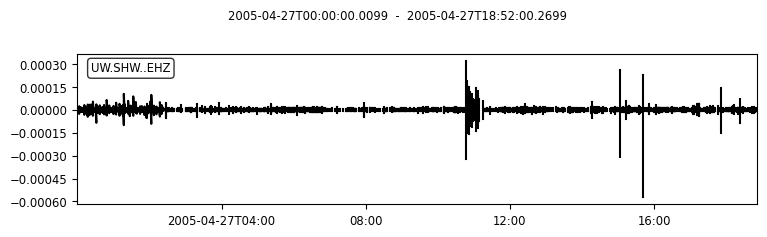

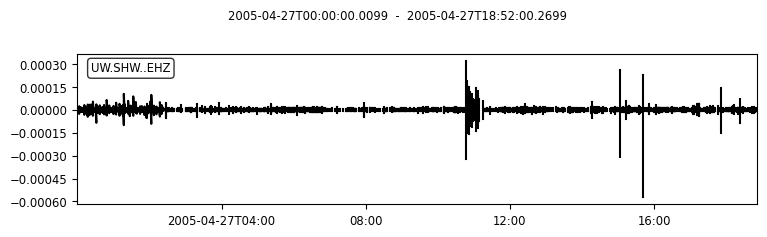

In [236]:
st.plot()

In [362]:
st

1255 Trace(s) in Stream:

UW.SHW..EHZ | 2005-04-27T00:00:00.009900Z - 2005-04-27T02:26:05.129900Z | 100.0 Hz, 876513 samples
...
(1253 other traces)
...
UW.SHW..EHZ | 2005-04-27T18:51:59.289900Z - 2005-04-27T18:52:00.269900Z | 100.0 Hz, 99 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [372]:
if len(st)>0: # if stream not empty 
    st_n = obspy.Stream()
    for i in range(1,len(st)): # i is the trace index
        t_diff = st[i].stats.starttime-st[i-1].stats.endtime
        if i == 1:
            tr_n = st[i-1]
            
        elif t_diff <= 60: # missing data for more than 60 sec
            tr_n = st[i].__add__(tr_n,fill_value='interpolate')
            
        elif t_diff > 60:
            st_n += tr_n
            tr_n = st[i-1]

print(st_n)

296 Trace(s) in Stream:

UW.SHW..EHZ | 2005-04-27T00:00:00.009900Z - 2005-04-27T02:32:11.129900Z | 100.0 Hz, 913113 samples
...
(294 other traces)
...
UW.SHW..EHZ | 2005-04-27T18:46:32.289900Z - 2005-04-27T18:46:33.269900Z | 100.0 Hz, 99 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [169]:
t_difff = st_r[1].stats.starttime-st_r[0].stats.endtime+600
t_difff

600.021

In [189]:
ii = (np.empty(math.ceil(t_difff/600)))
ii.fill(np.nan)
ii

array([nan, nan])

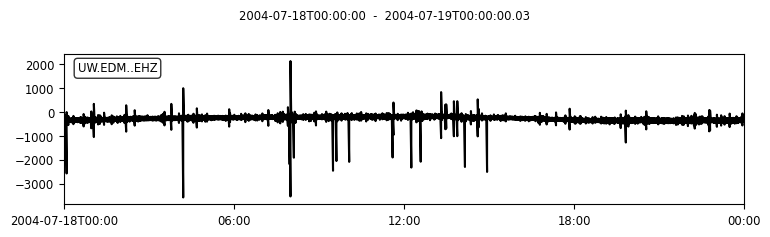

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-07-18T00:00:00.000000Z - 2004-07-19T00:00:00.030000Z | 100.0 Hz, 8640004 samples

In [38]:
st = client.get_waveforms(network=net, station='EDM', channel=cha,
                                       year='{}'.format(2004), doy='{}'.format(200))

st.plot()
st

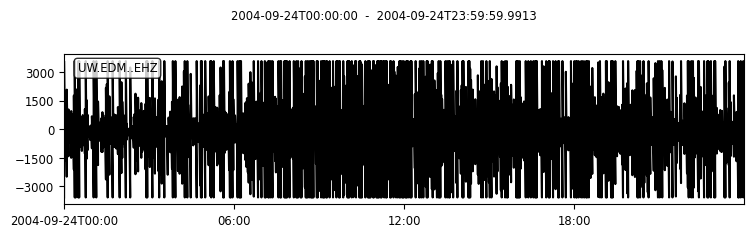

5 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-24T00:00:00.000000Z - 2004-09-24T00:40:20.060000Z | 100.0 Hz, 242007 samples
UW.EDM..EHZ | 2004-09-24T00:40:20.081000Z - 2004-09-24T01:39:10.071000Z | 100.0 Hz, 353000 samples
UW.EDM..EHZ | 2004-09-24T01:39:10.091000Z - 2004-09-24T02:38:10.081000Z | 100.0 Hz, 354000 samples
UW.EDM..EHZ | 2004-09-24T02:38:10.100900Z - 2004-09-24T15:50:15.230900Z | 100.0 Hz, 4752514 samples
UW.EDM..EHZ | 2004-09-24T15:50:33.251300Z - 2004-09-24T23:59:59.991300Z | 100.0 Hz, 2936675 samples

In [39]:
st = client.get_waveforms(network=net, station='EDM', channel=cha,
                                       year='{}'.format(2004), doy='{}'.format(268))

st.plot()
st

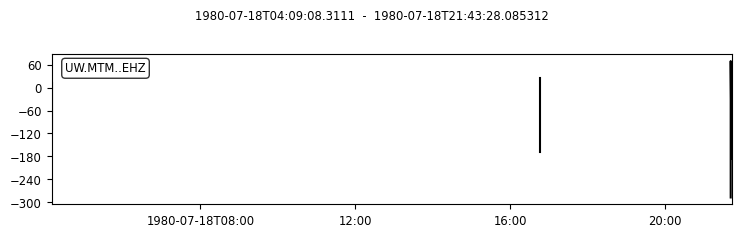

3 Trace(s) in Stream:
UW.MTM..EHZ | 1980-07-18T04:09:08.311100Z - 1980-07-18T04:09:26.208572Z | 100.1 Hz, 1792 samples
UW.MTM..EHZ | 1980-07-18T16:46:02.435200Z - 1980-07-18T16:46:30.565509Z | 100.1 Hz, 2816 samples
UW.MTM..EHZ | 1980-07-18T21:42:03.674400Z - 1980-07-18T21:43:28.085312Z | 100.1 Hz, 8448 samples

In [37]:
st = client.get_waveforms(network=net, station='MTM', channel=cha,
                                       year='{}'.format(1980), doy='{}'.format(200))

st.plot()
st

In [268]:
st_n = obspy.Stream()
for i in range(len(st_c)-1):
    t_diff = st[i+1].stats.starttime-st[i].stats.endtime
    if t_diff <= 60: # missing data for more than 60 sec
        st_n += st[i+1].__add__(st[i],fill_value='interpolate')

In [263]:
st_c[i+1].__add__(st_c[i],fill_value='interpolate')

UW.SHW..EHZ | 2005-04-27T18:51:21.289900Z - 2005-04-27T18:52:00.269900Z | 100.0 Hz, 3899 samples

In [269]:
print(st_n.__str__(extended=True))

958 Trace(s) in Stream:
UW.SHW..EHZ | 2005-04-27T00:00:00.009900Z - 2005-04-27T02:26:36.129900Z | 100.0 Hz, 879613 samples
UW.SHW..EHZ | 2005-04-27T02:26:35.150000Z - 2005-04-27T02:26:38.130000Z | 100.0 Hz, 299 samples
UW.SHW..EHZ | 2005-04-27T02:26:37.150000Z - 2005-04-27T02:26:57.130000Z | 100.0 Hz, 1999 samples
UW.SHW..EHZ | 2005-04-27T02:26:56.150000Z - 2005-04-27T02:27:37.130000Z | 100.0 Hz, 4099 samples
UW.SHW..EHZ | 2005-04-27T02:27:36.150000Z - 2005-04-27T02:27:43.130000Z | 100.0 Hz, 699 samples
UW.SHW..EHZ | 2005-04-27T02:27:42.150000Z - 2005-04-27T02:28:16.130000Z | 100.0 Hz, 3399 samples
UW.SHW..EHZ | 2005-04-27T02:28:15.149900Z - 2005-04-27T02:28:25.129900Z | 100.0 Hz, 999 samples
UW.SHW..EHZ | 2005-04-27T02:28:24.149900Z - 2005-04-27T02:28:30.129900Z | 100.0 Hz, 599 samples
UW.SHW..EHZ | 2005-04-27T02:28:29.149900Z - 2005-04-27T02:28:39.129900Z | 100.0 Hz, 999 samples
UW.SHW..EHZ | 2005-04-27T02:28:38.149900Z - 2005-04-27T02:29:35.129900Z | 100.0 Hz, 5699 samples
UW.SHW..E

:) year=2005, jday=119, net=UW, sta=SHW, cha=EHZ


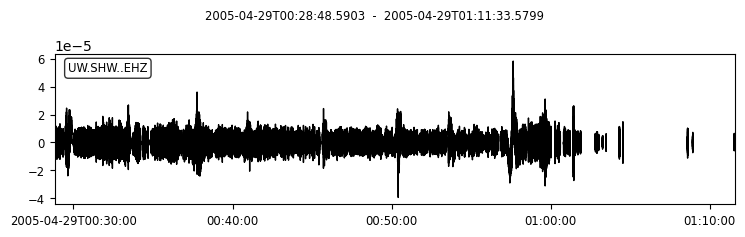

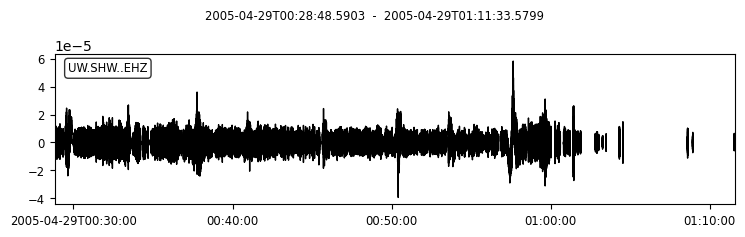

In [278]:
year = 2005
jday = 119#119
sta = 'SHW'

freqs_names = ['rsam','mf','hf','dsar','ndsar']
df = pd.DataFrame(columns=freqs_names)
daysec = 24*3600
freqs = [[2,5], [4.5,8], [8,16]]

# RSAM_list = []
# MF_list = []
# HF_list = []
# DSAR_list = []
# nDSAR_list =[]

st = preprocessing(year,jday, net, sta, cha)
st.plot()

# Outliers

In [ ]:
import numpy as np
import scipy
import math

:) year=2004, jday=275, net=UW, sta=EDM, cha=EHZ


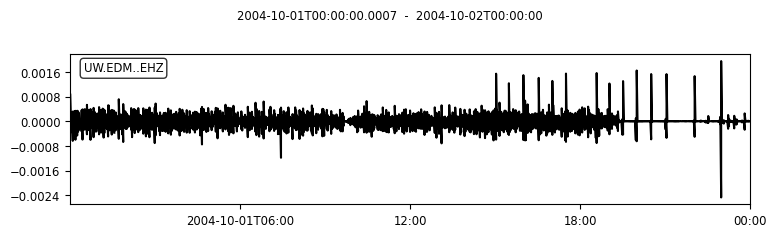

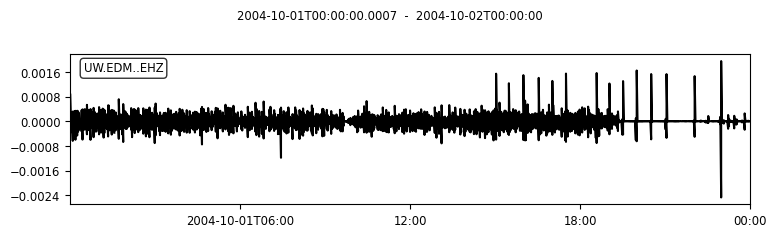

In [313]:
year = 2004
jday = 275#119
et = 'UW'
sta = 'EDM'
cha = 'EHZ'

st = preprocessing(year,jday, net, sta, cha)
st.plot()

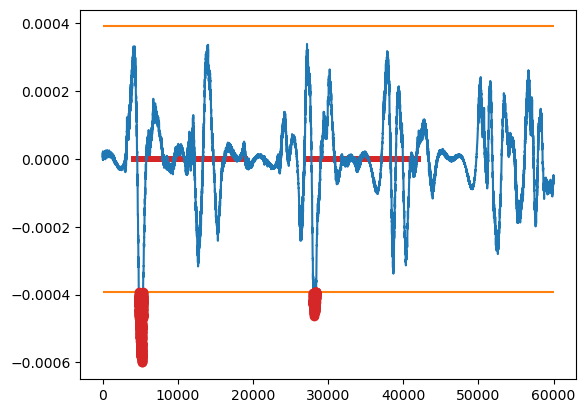

In [329]:
randdata = st[0].data[100*10*60*1:100*10*60*2]#np.random.normal(size=10000)#*np.exp(np.linspace(0,2,10000))
randstd1 = np.std(randdata)*3.2
randstd2 = -np.std(randdata)*3.2
samples = np.arange(len(randdata))
plt.plot(samples, randdata)
plt.hlines(randstd1, 0,len(randdata), color='C1')
plt.hlines(randstd2, 0,len(randdata), color='C1')
peaks = samples[(randstd2>randdata) | (randdata>randstd1)]
plt.plot(peaks, randdata[peaks], linestyle='', marker='o', color='C3')
# plt.hlines(randdata[peaks], peaks-10*100,peaks+140*100, color='C1')
# plt.hlines(np.full(len(peaks),randstd), peaks-10*100,peaks+140*100, color='C3', linewidth=3)
plt.hlines(np.full(len(peaks),0), peaks-10*100,peaks+140*100, color='C3', linewidth=3)

# peaks1, _ = scipy.signal.find_peaks(randdata, threshold=3)
# plt.plot(peaks1, randdata[peaks1], linestyle='', marker='o', color='C2')


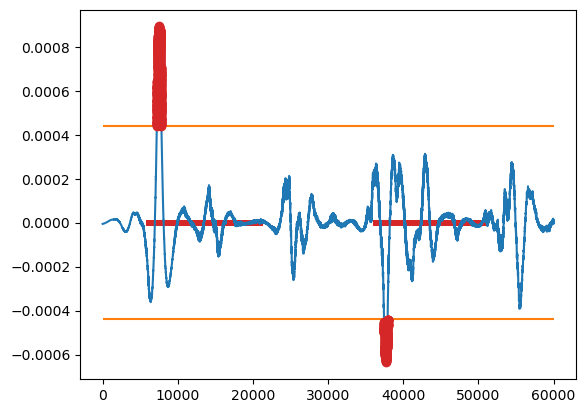

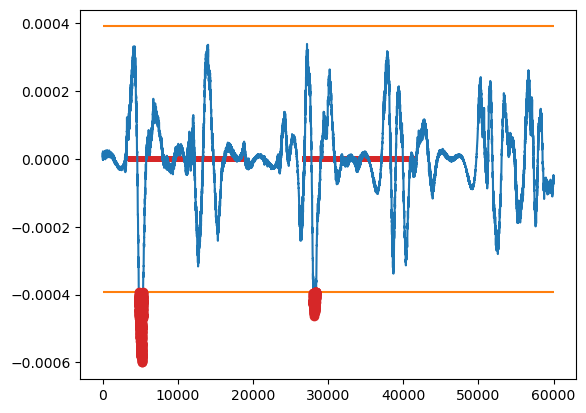

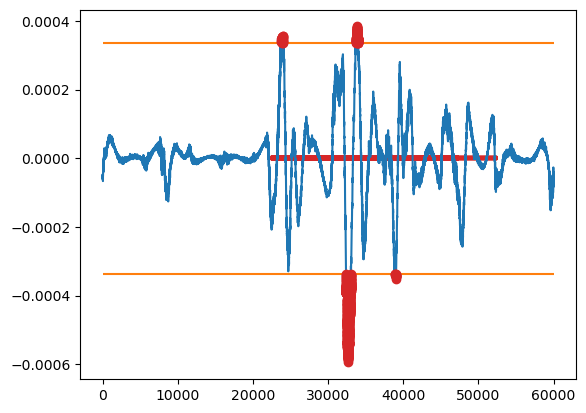

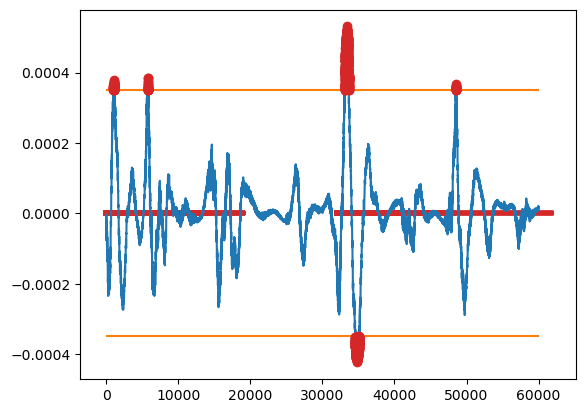

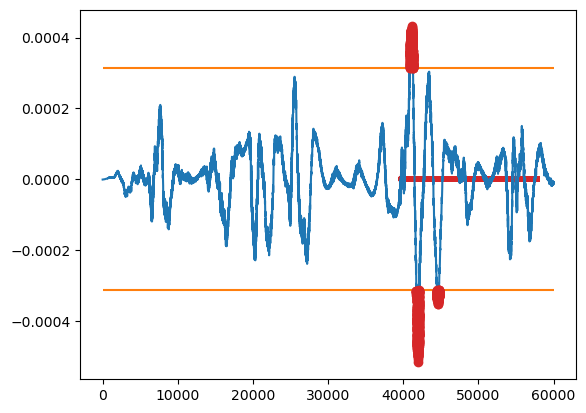

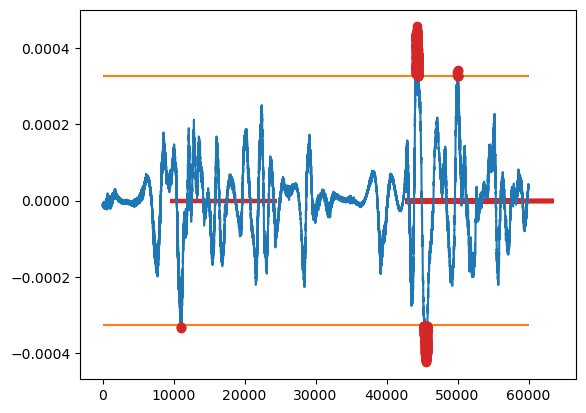

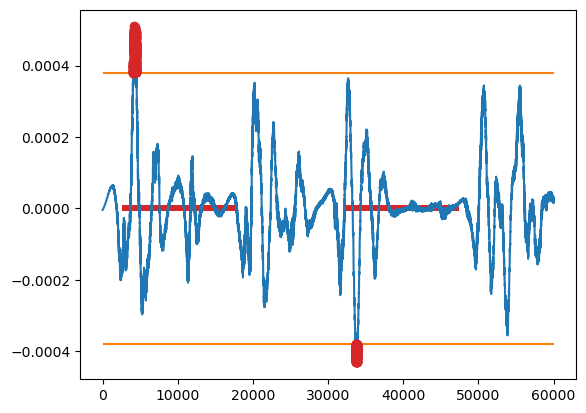

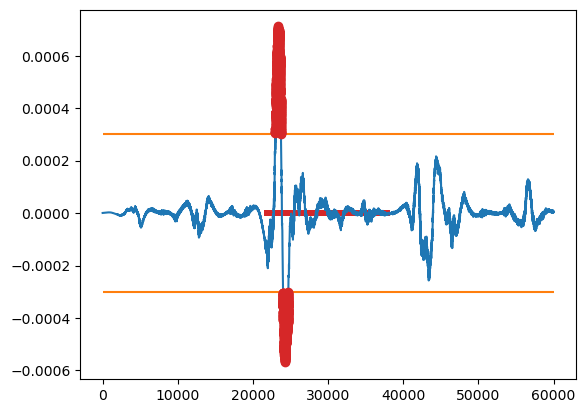

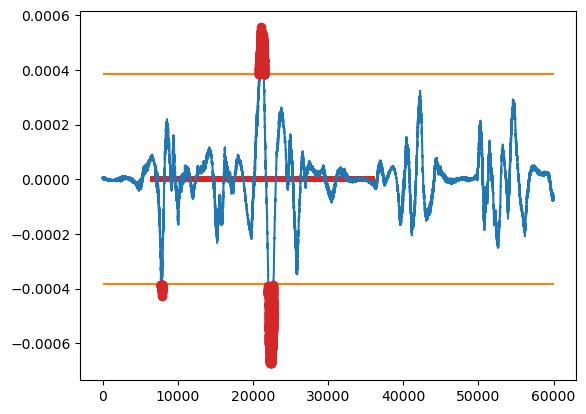

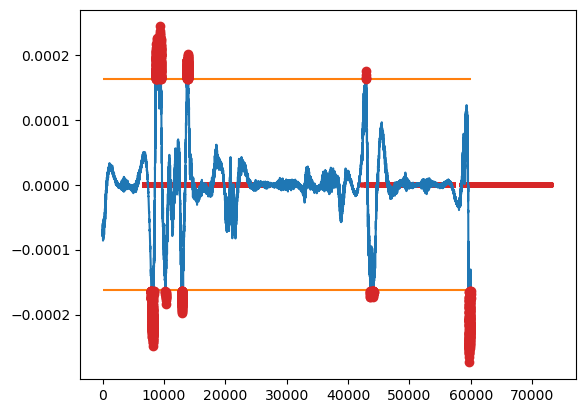

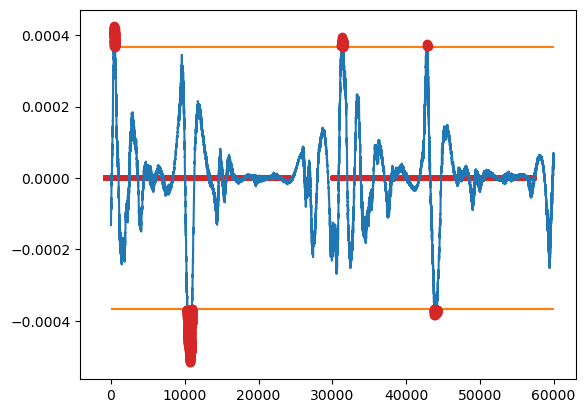

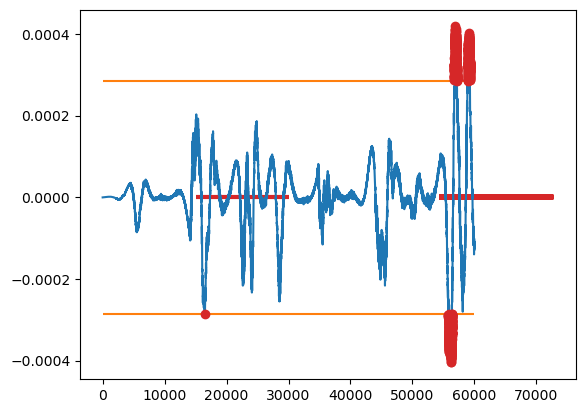

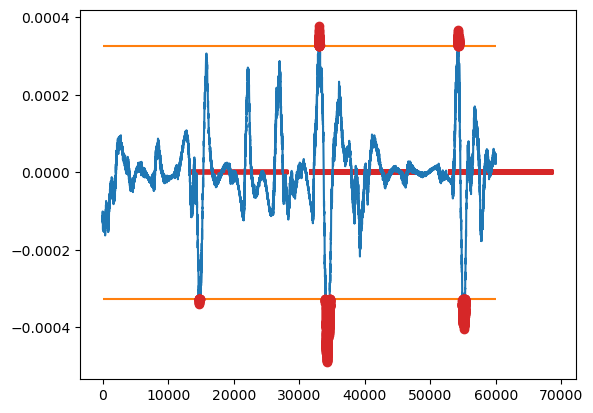

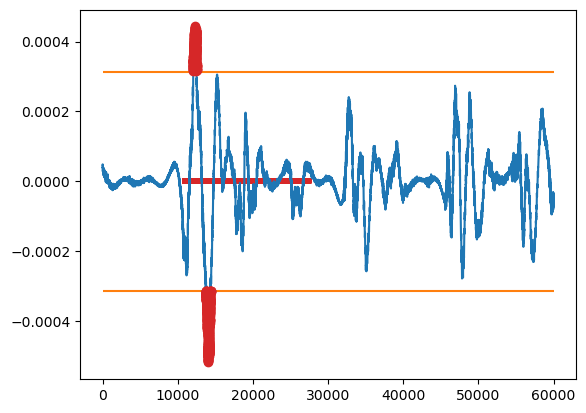

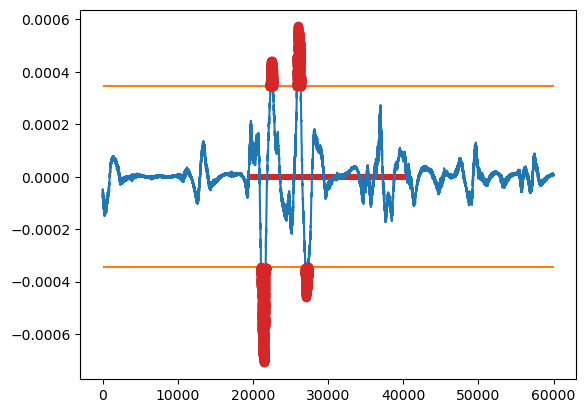

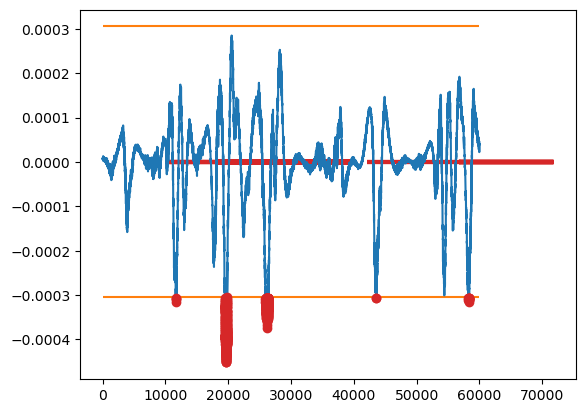

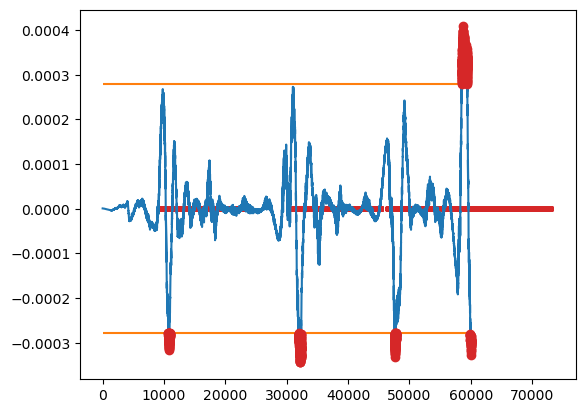

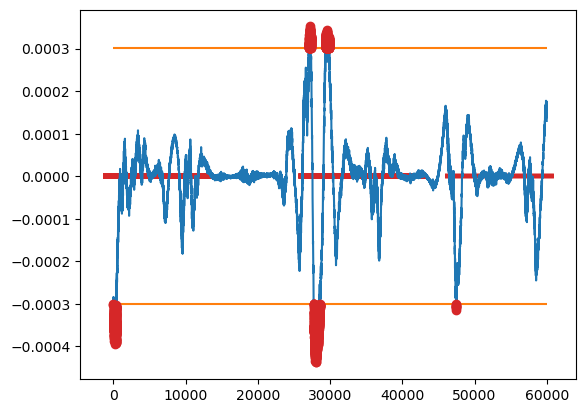

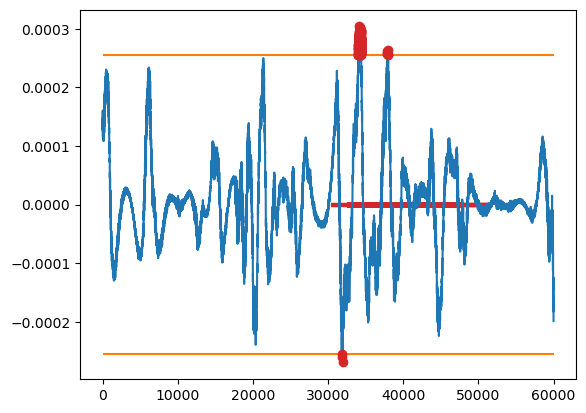

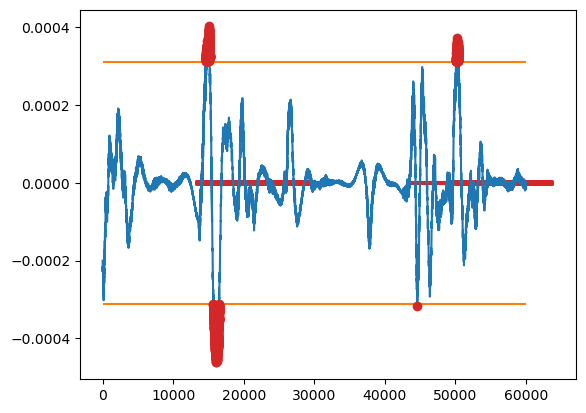

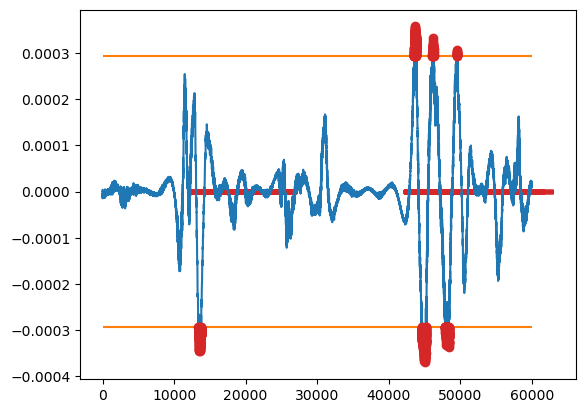

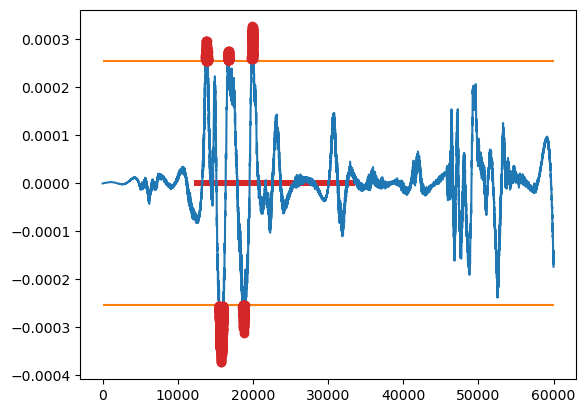

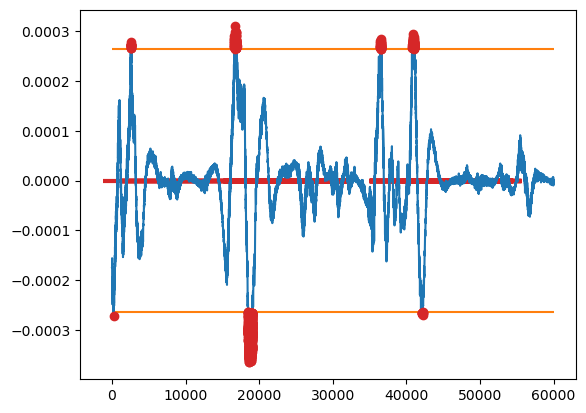

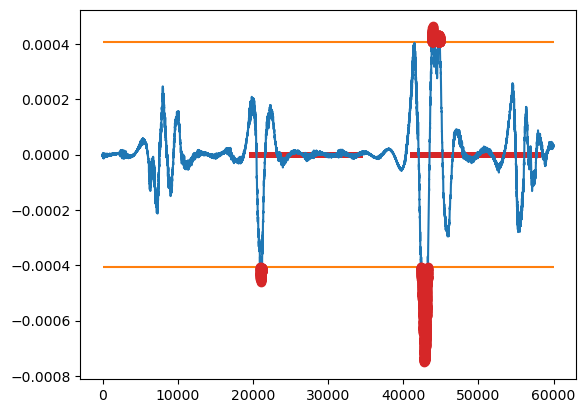

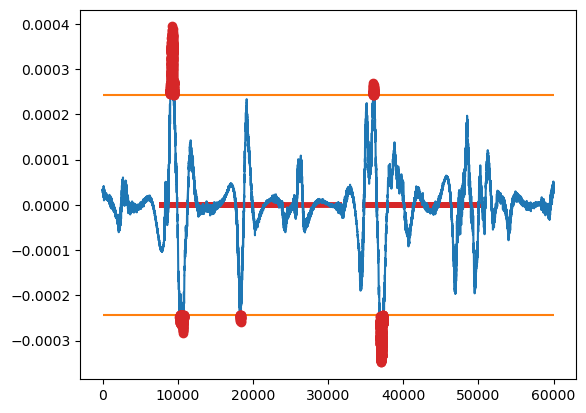

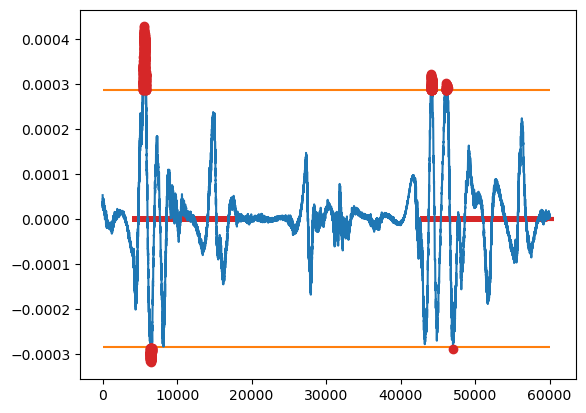

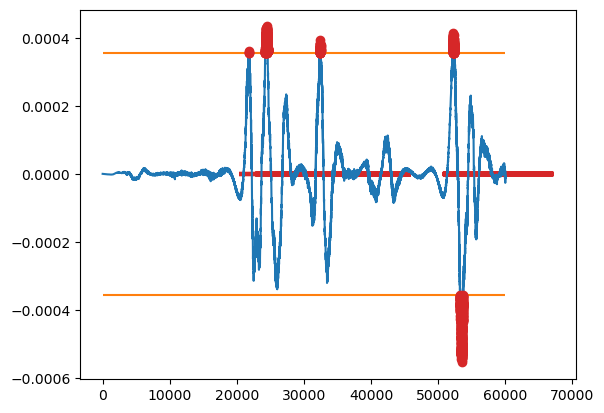

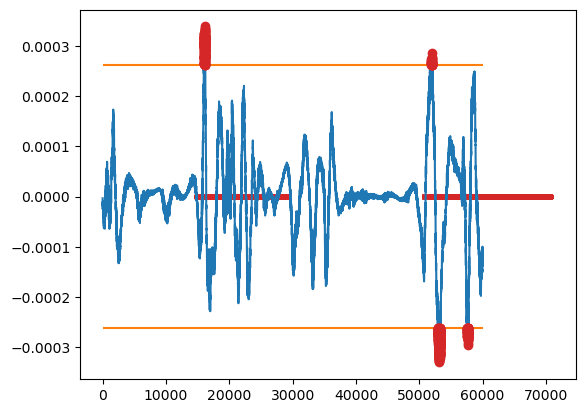

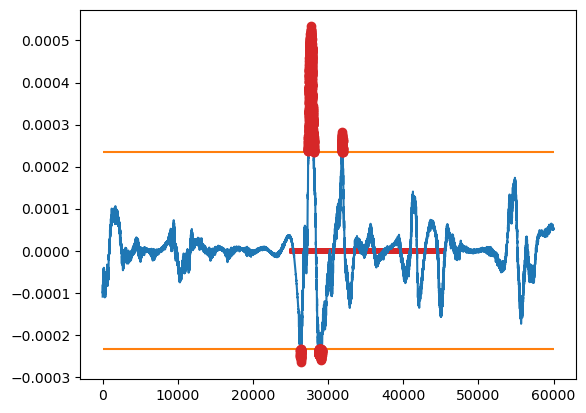

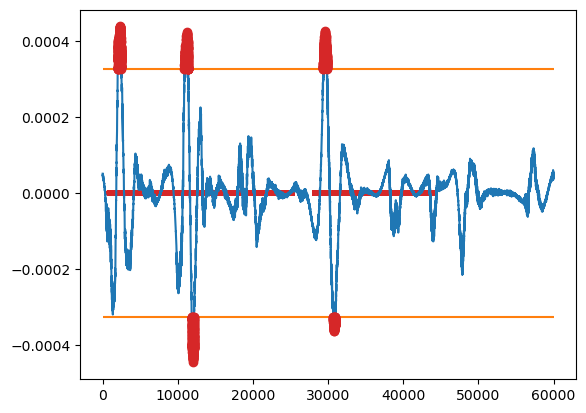

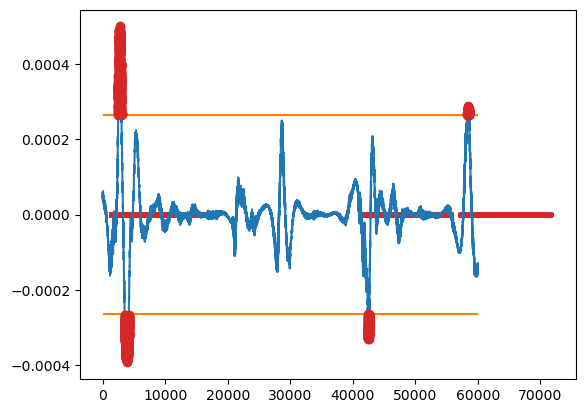

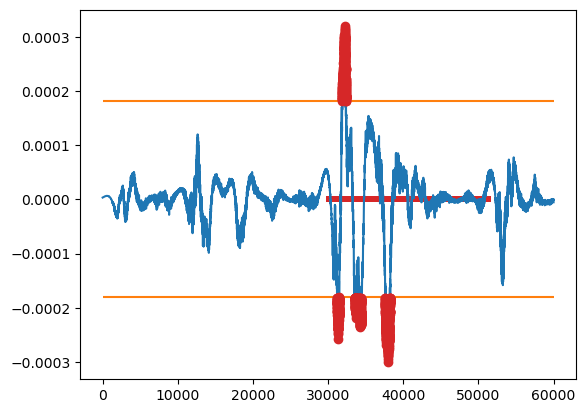

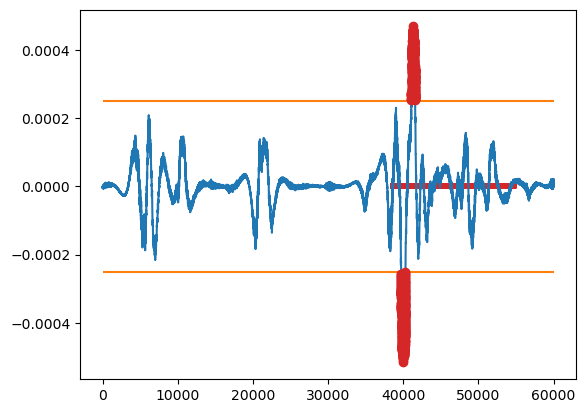

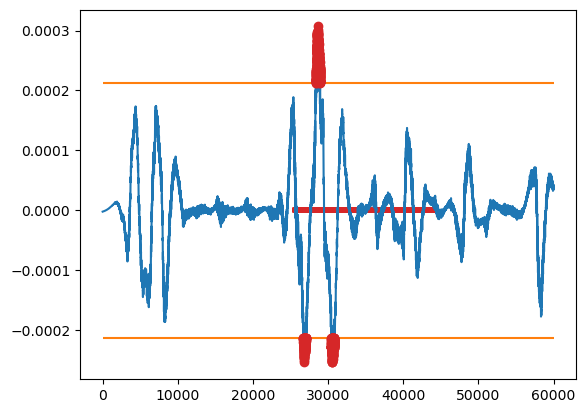

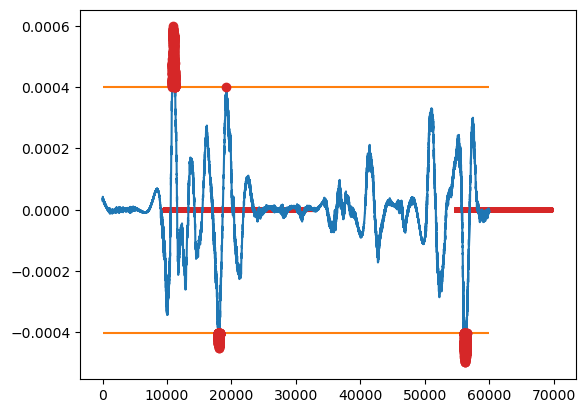

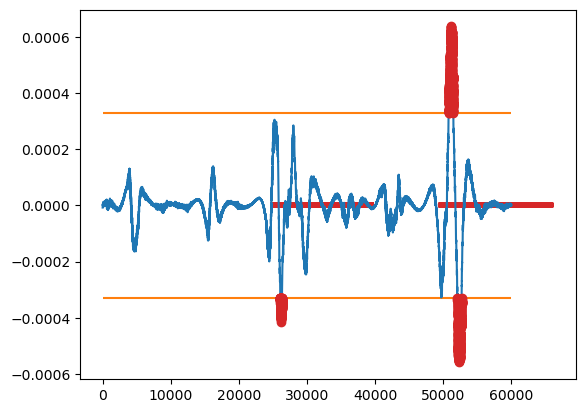

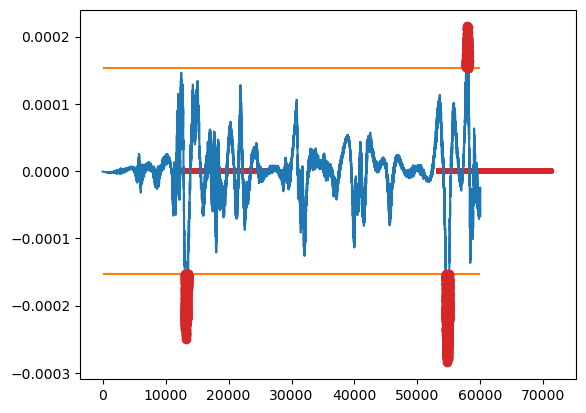

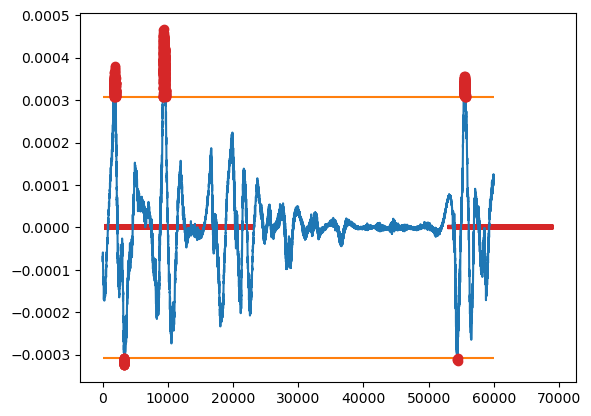

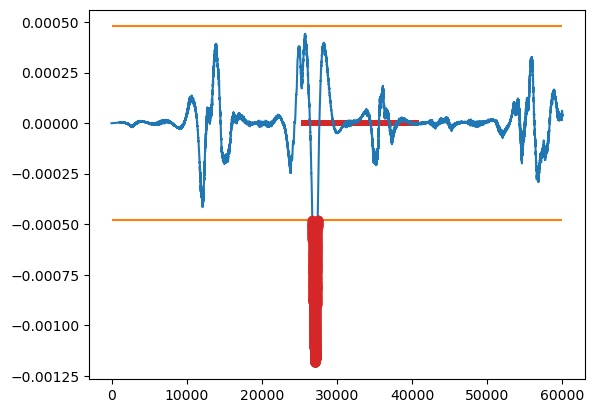

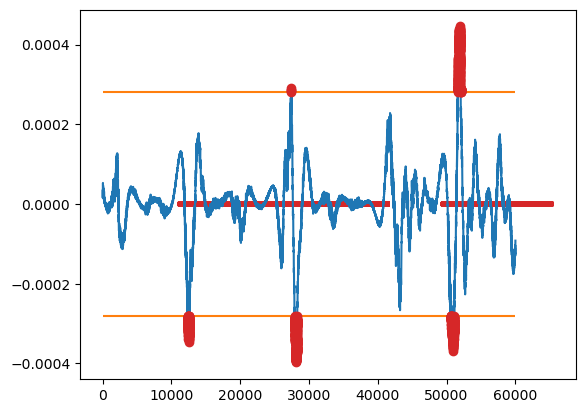

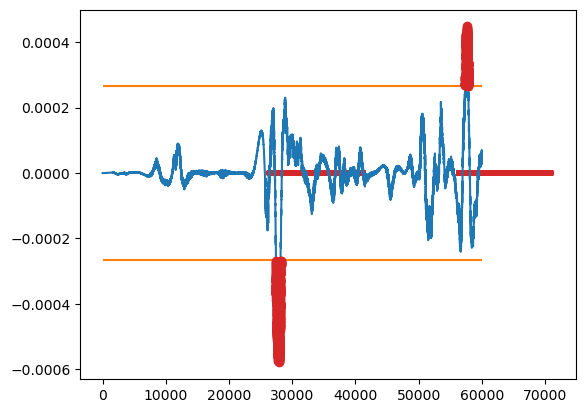

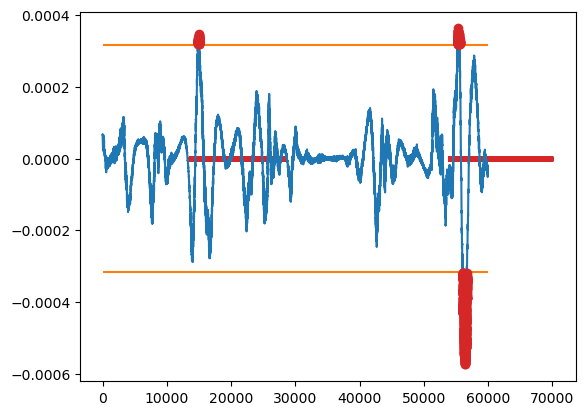

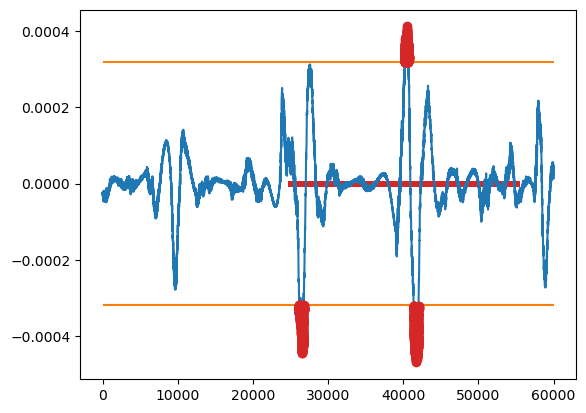

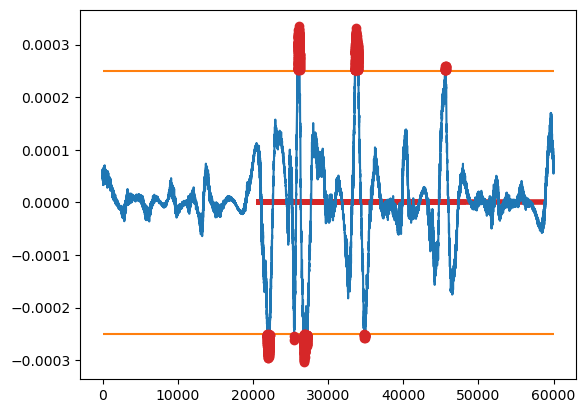

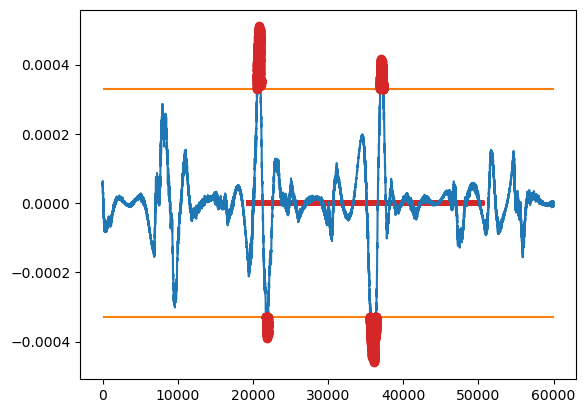

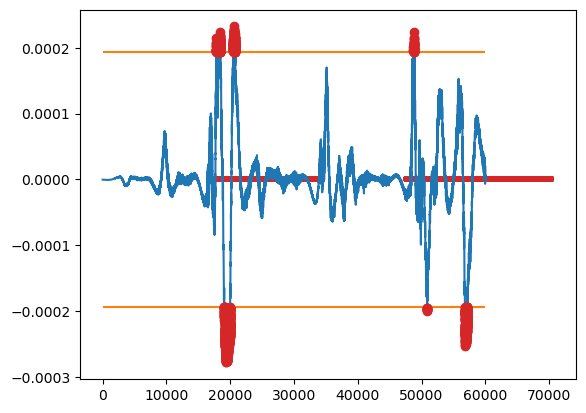

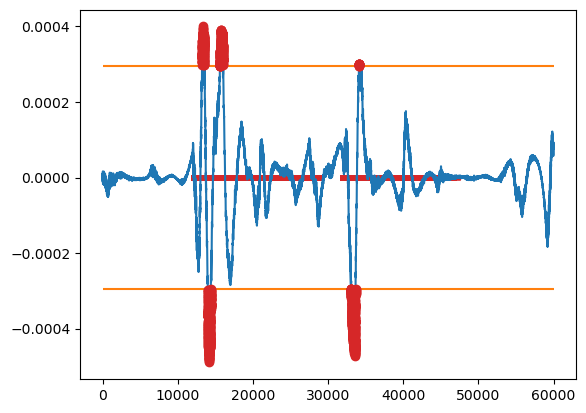

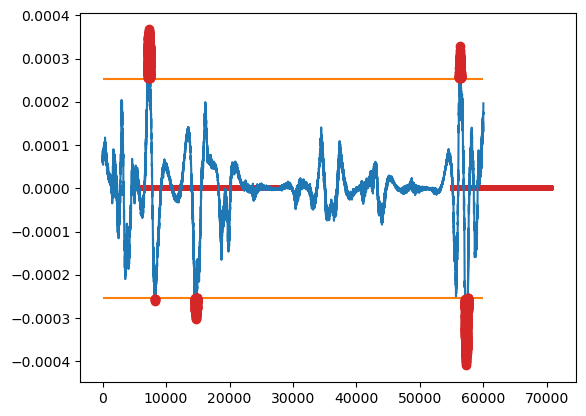

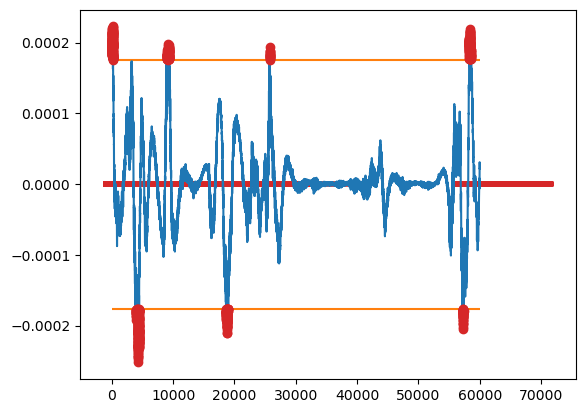

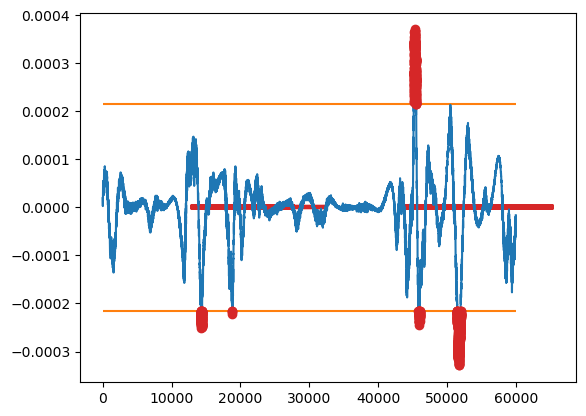

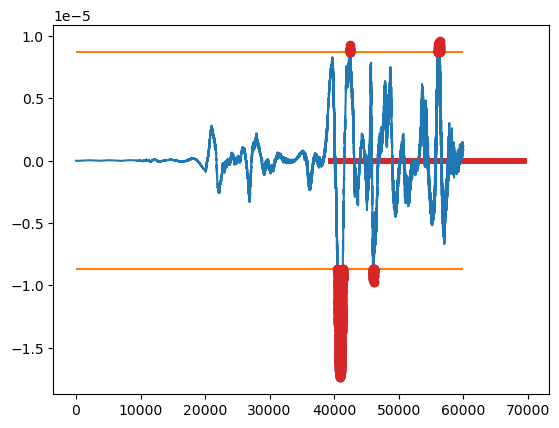

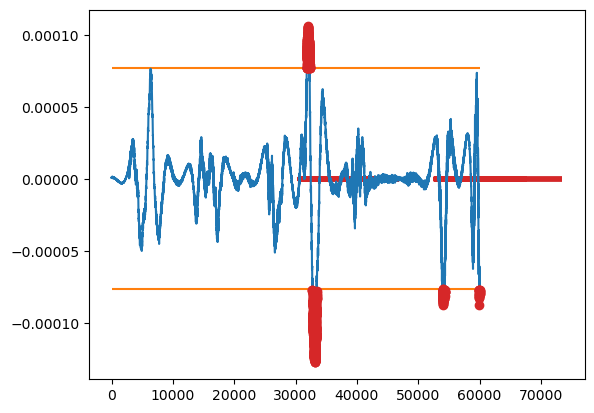

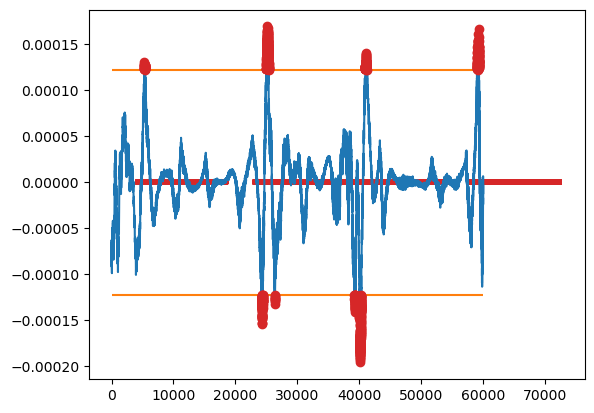

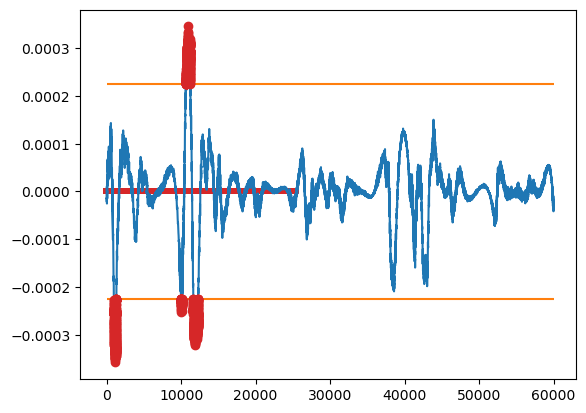

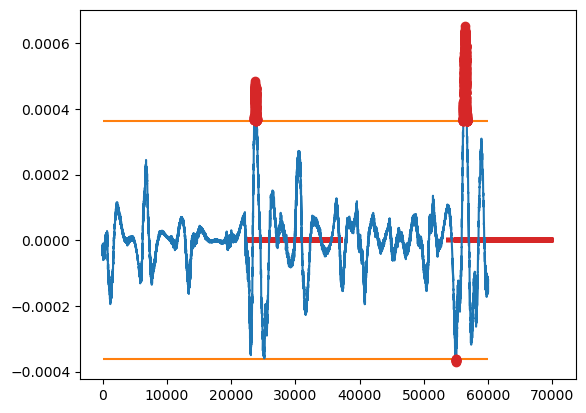

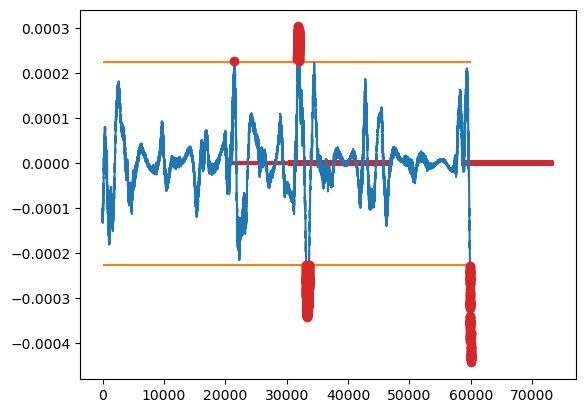

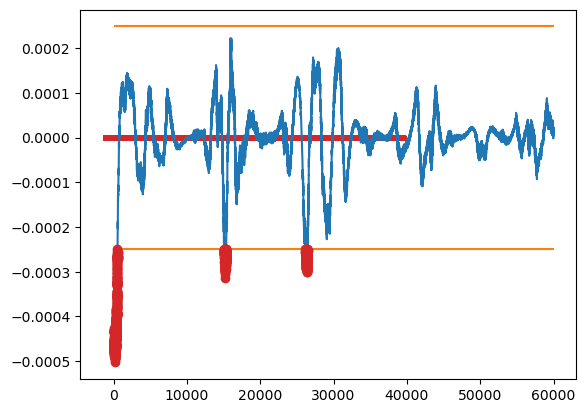

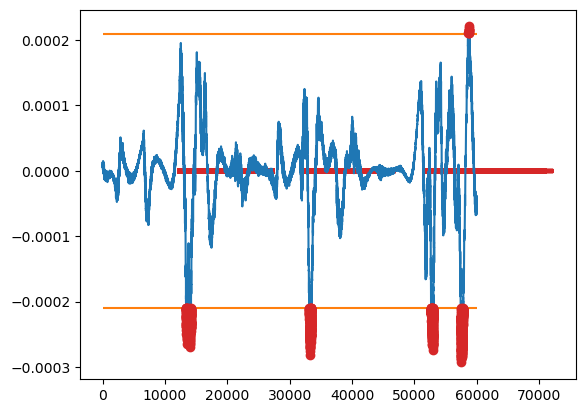

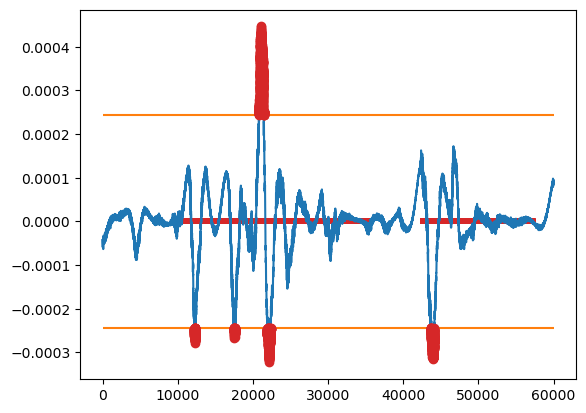

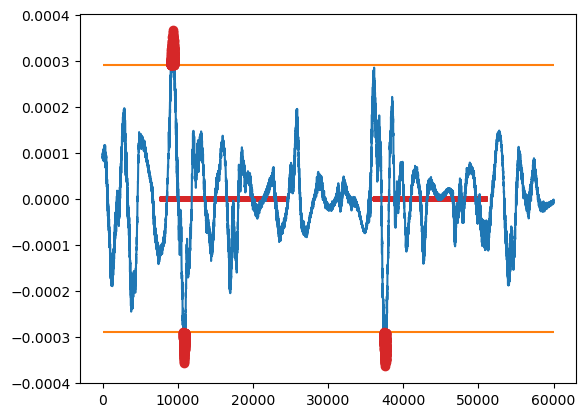

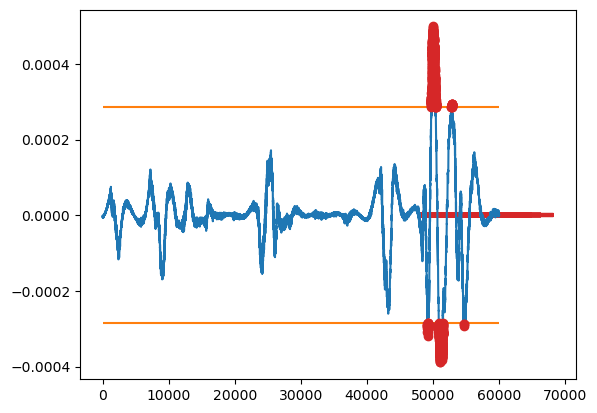

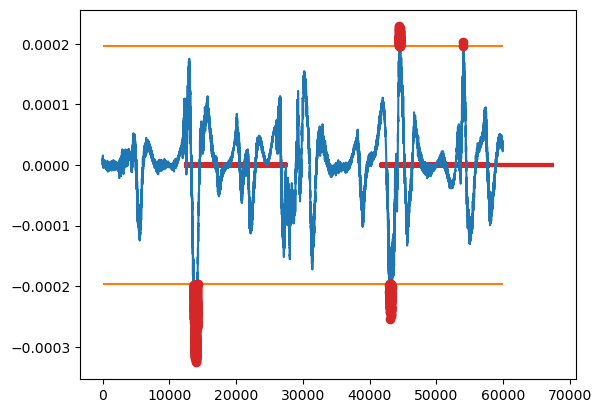

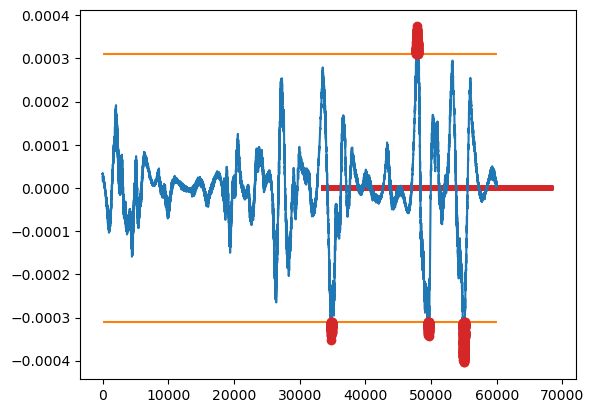

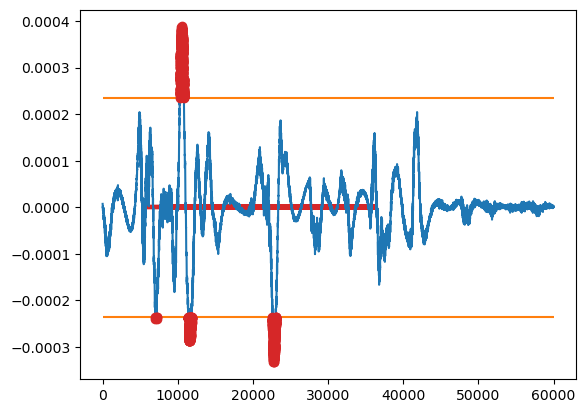

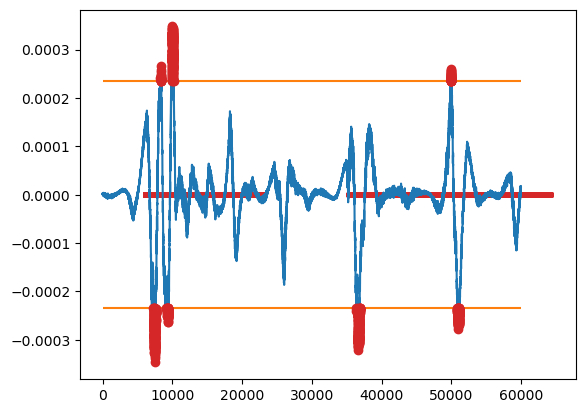

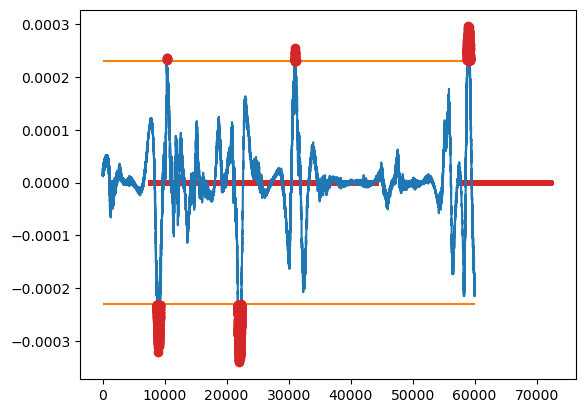

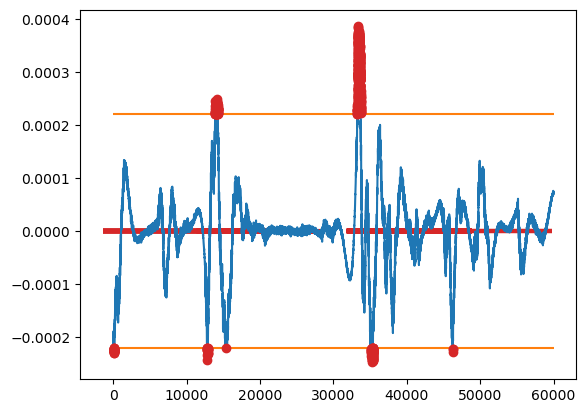

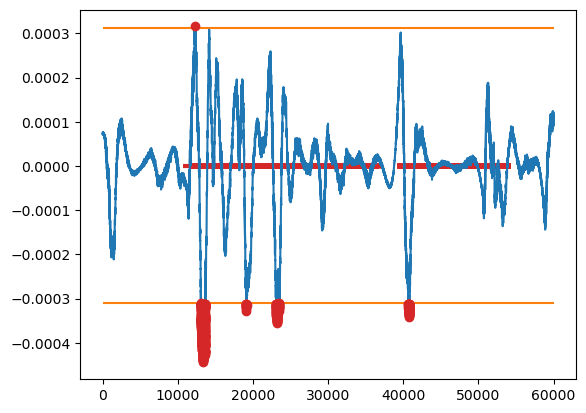

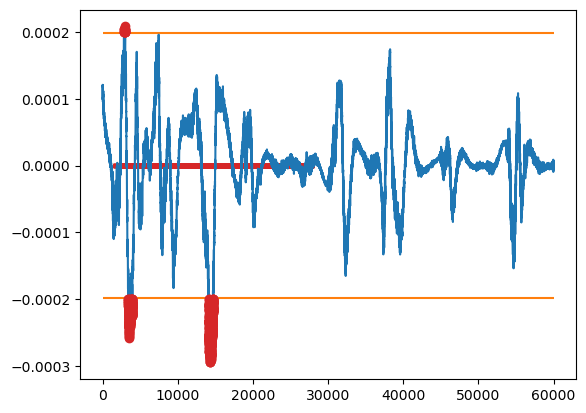

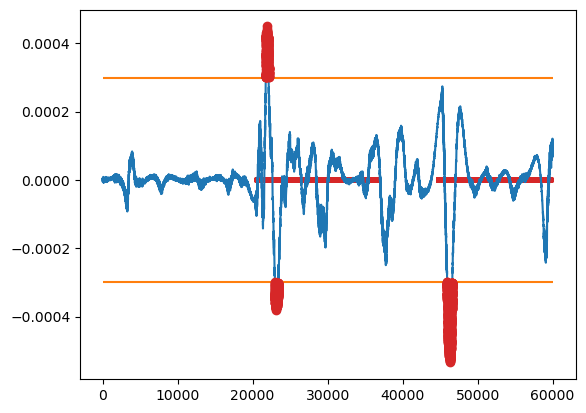

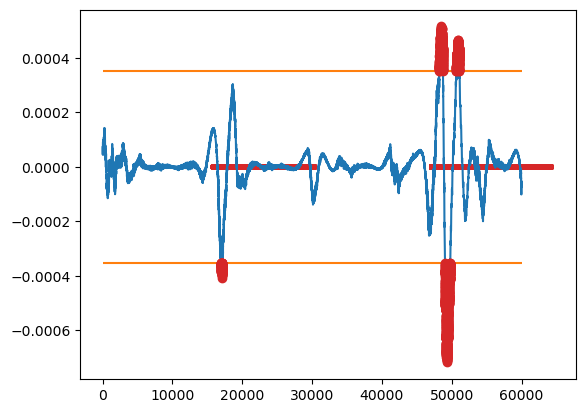

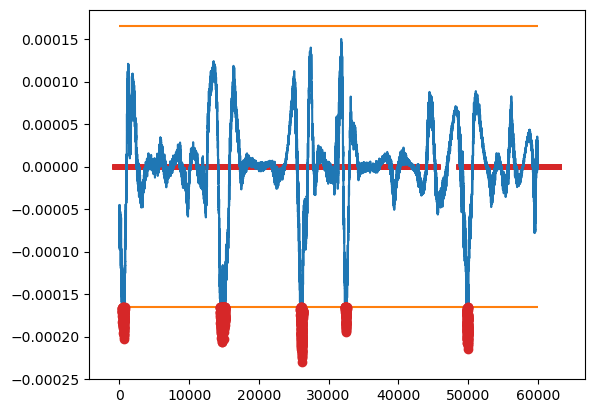

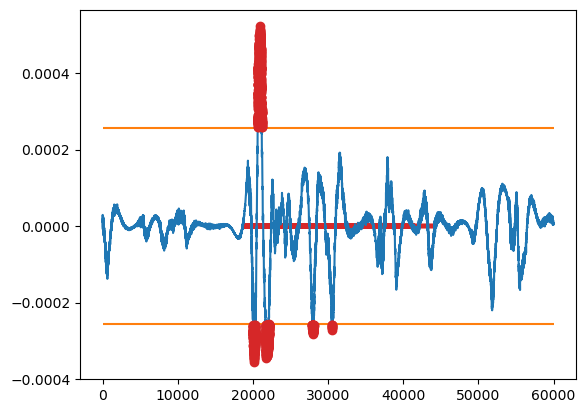

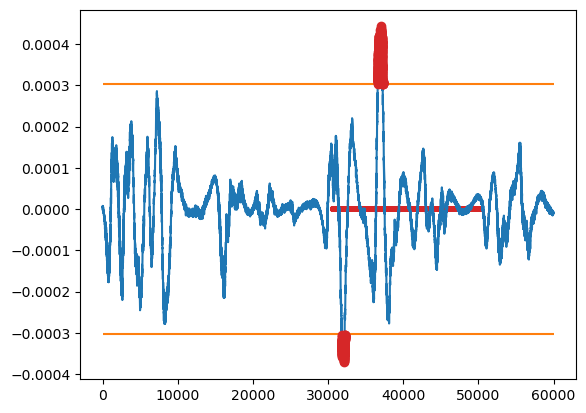

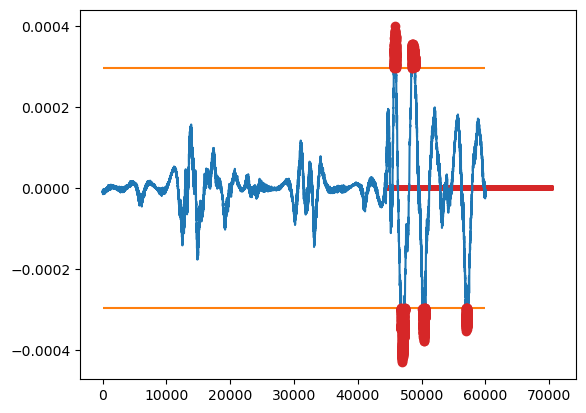

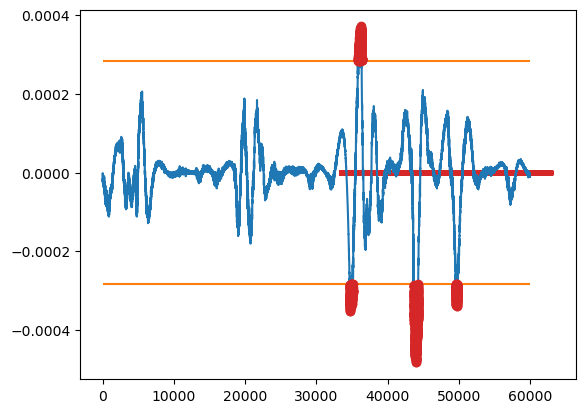

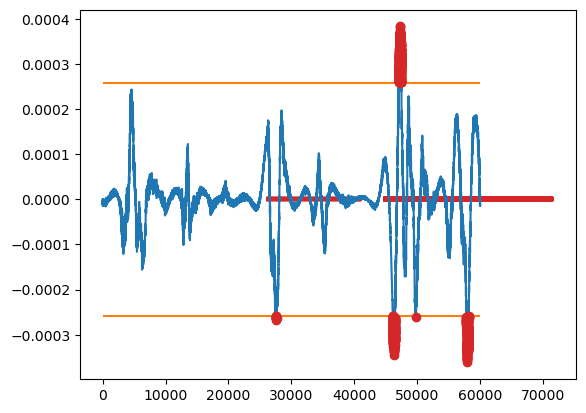

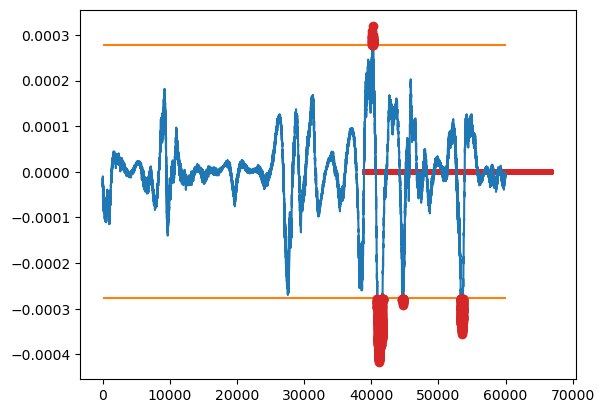

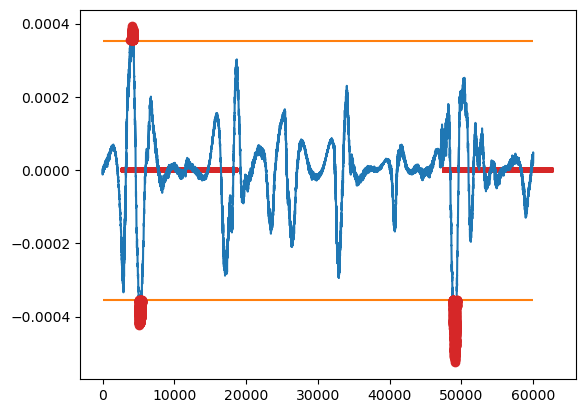

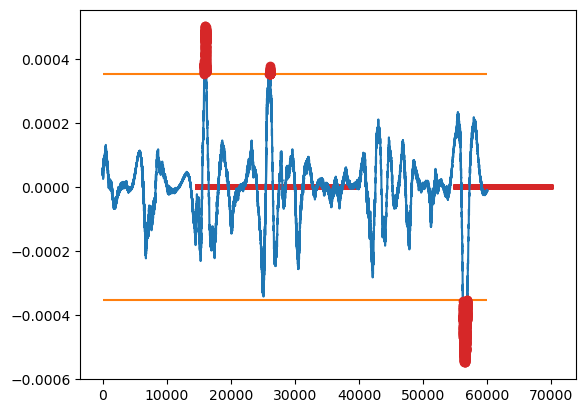

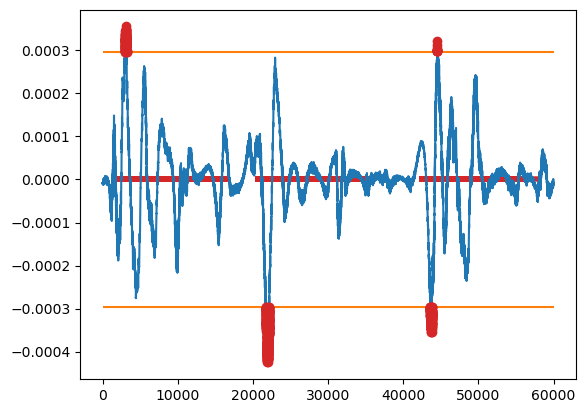

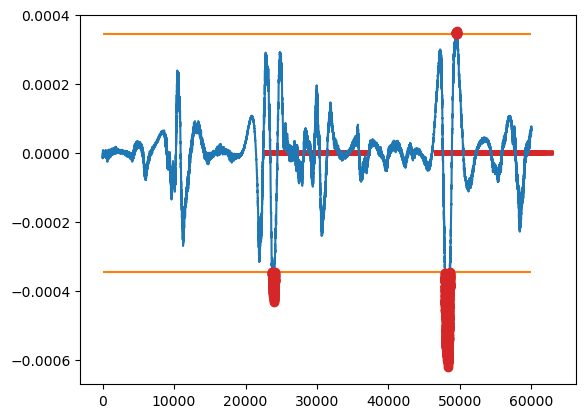

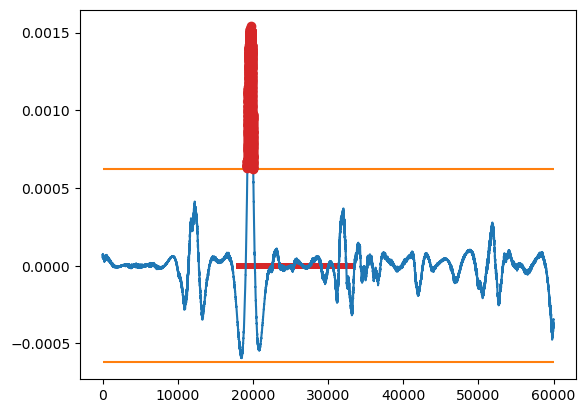

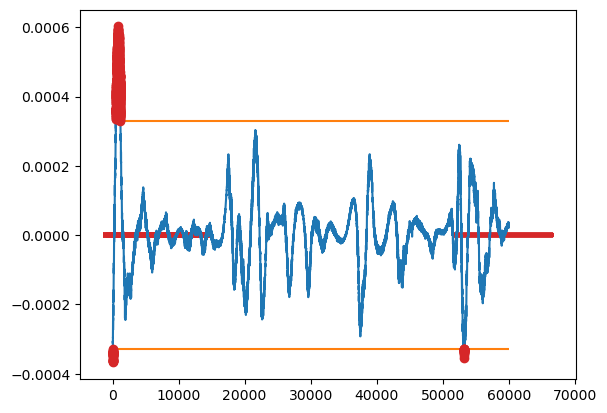

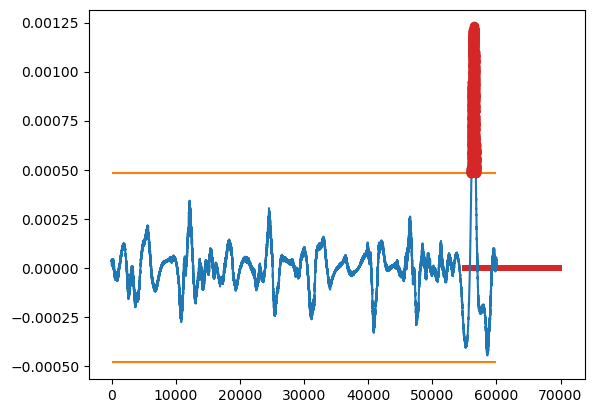

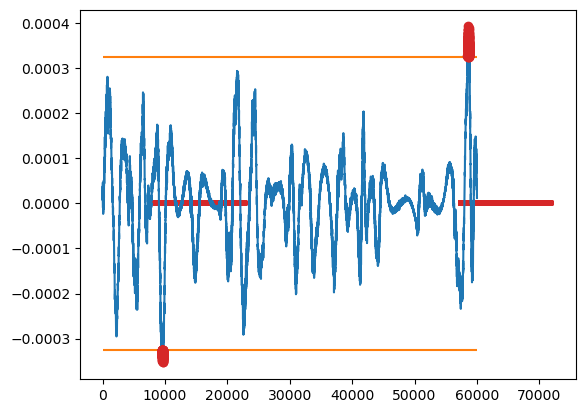

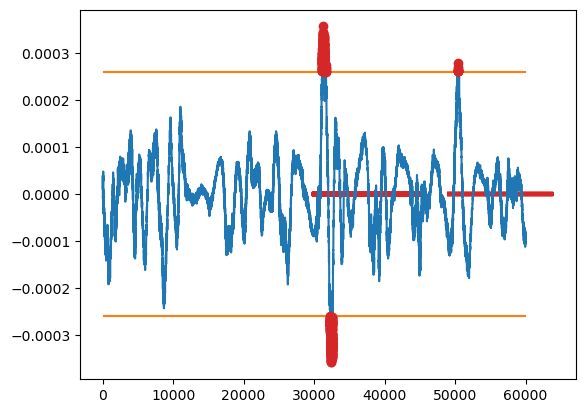

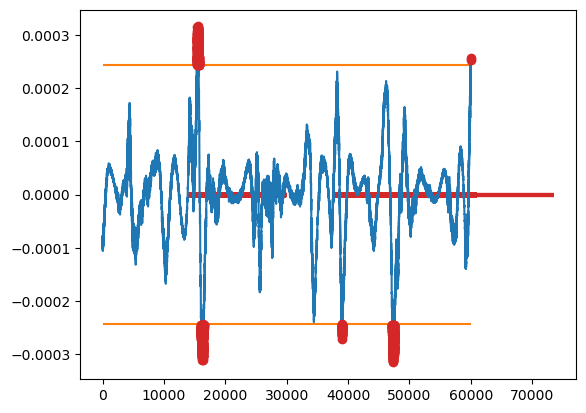

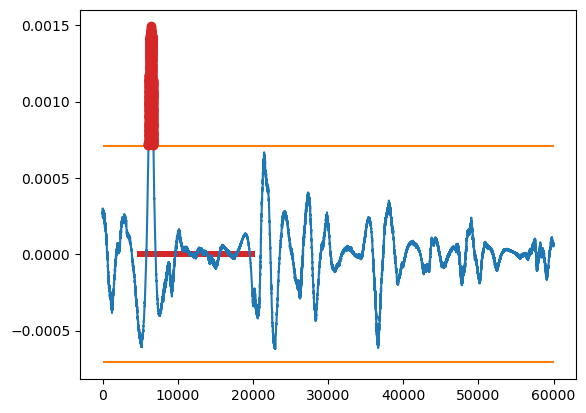

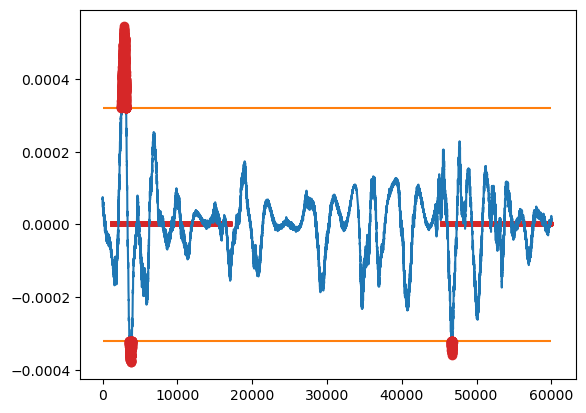

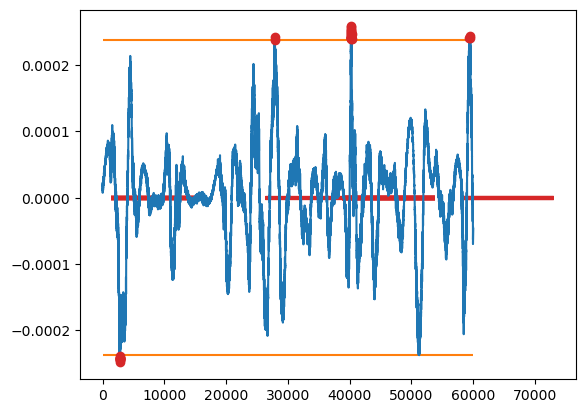

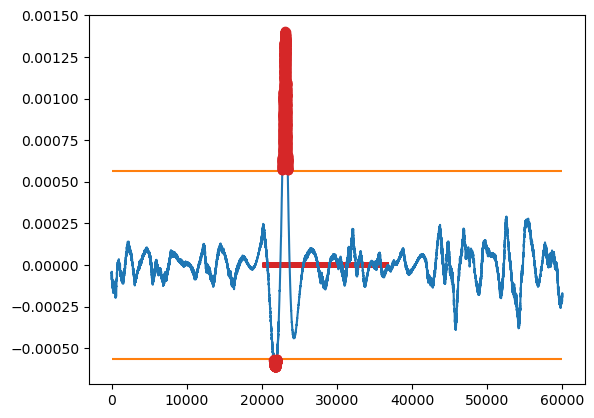

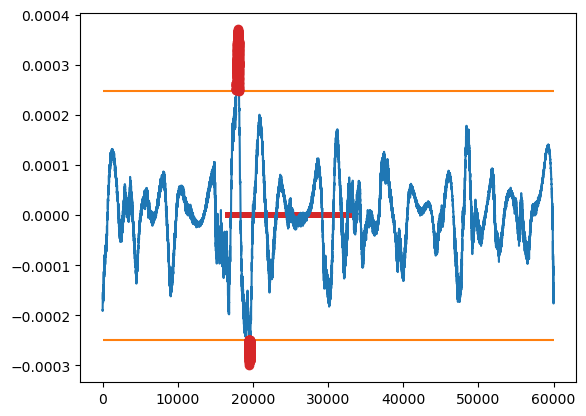

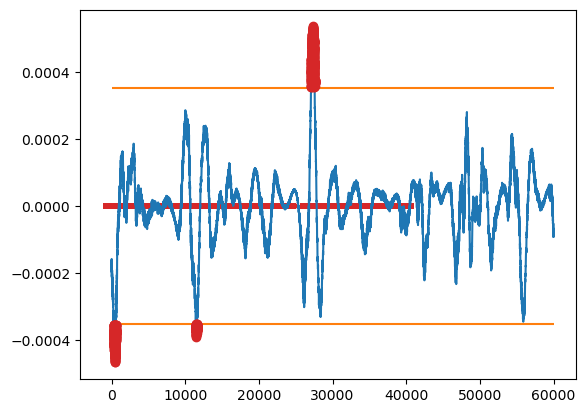

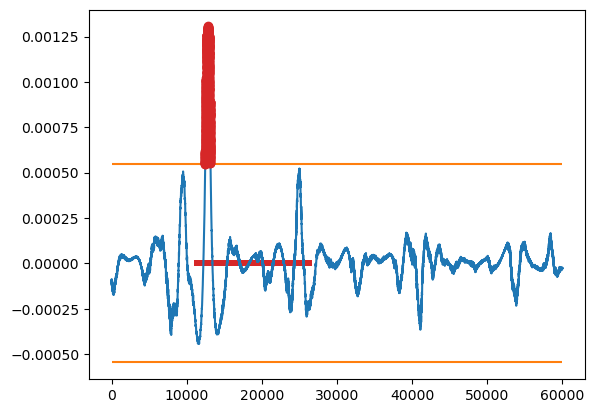

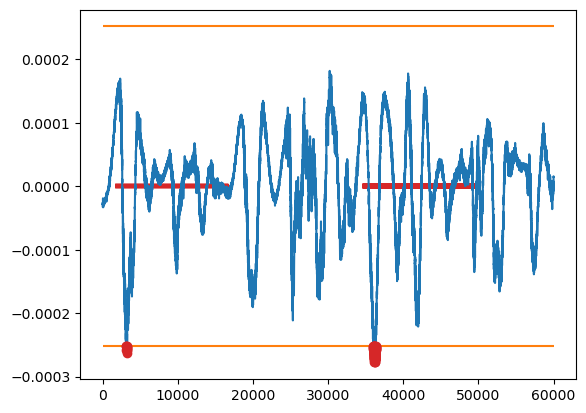

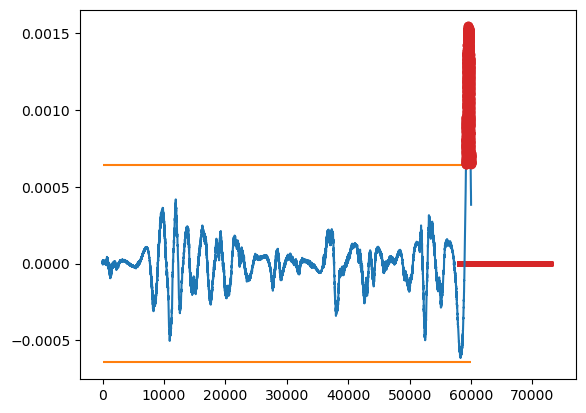

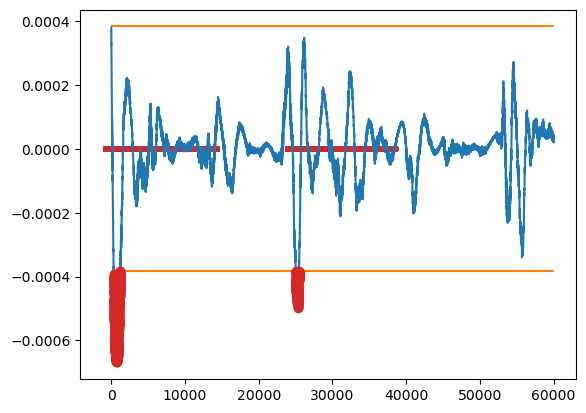

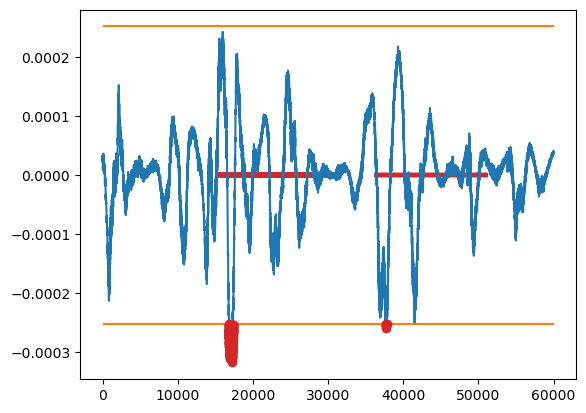

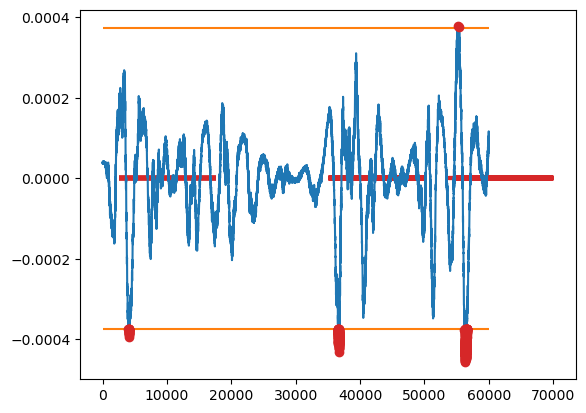

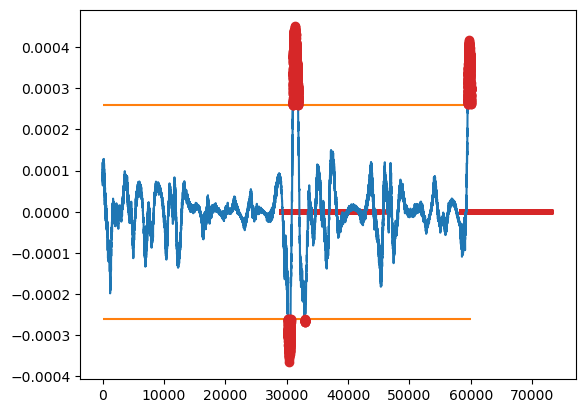

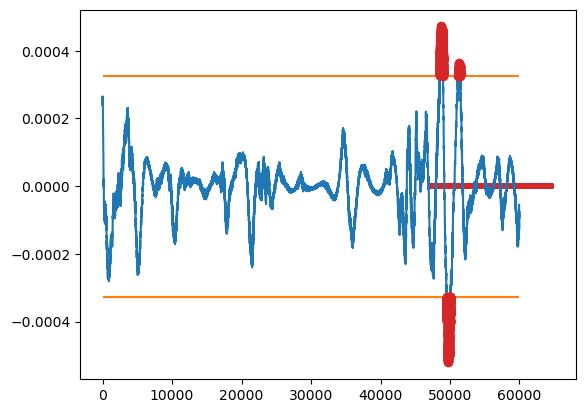

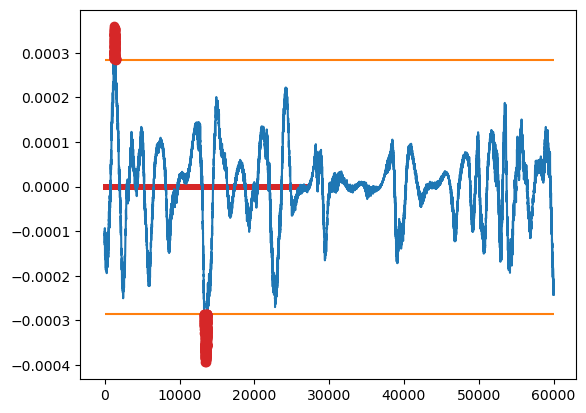

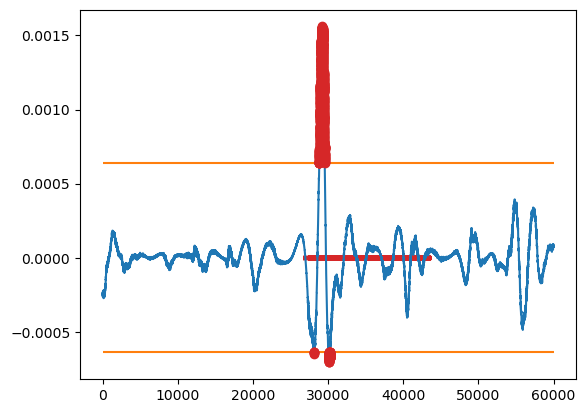

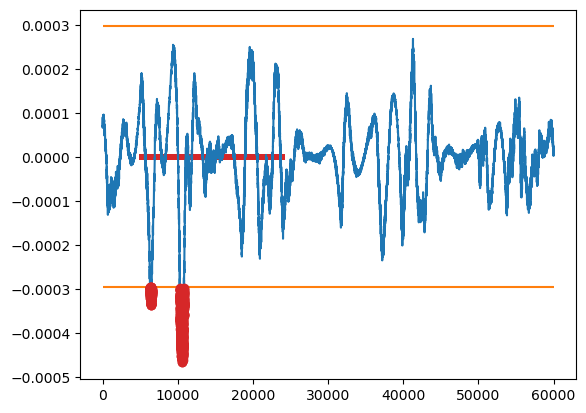

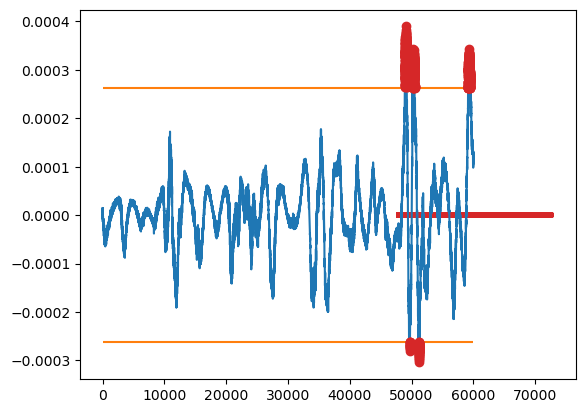

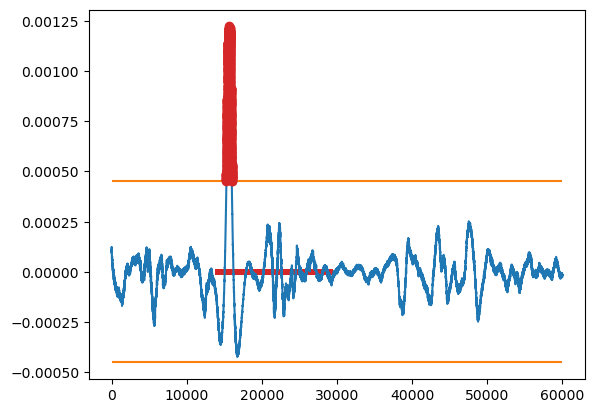

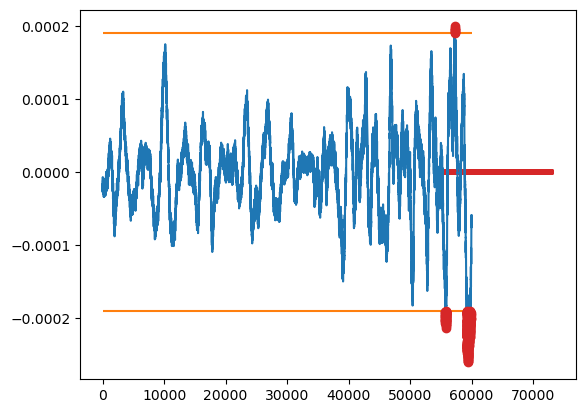

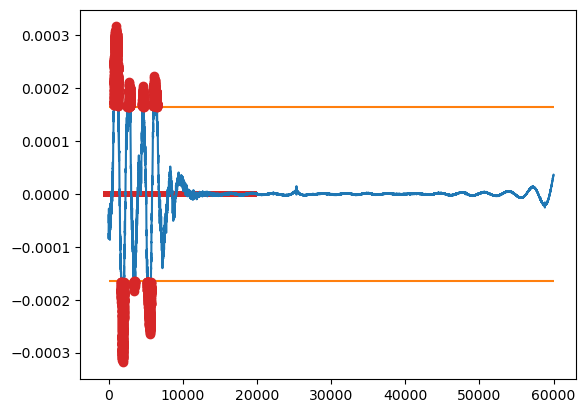

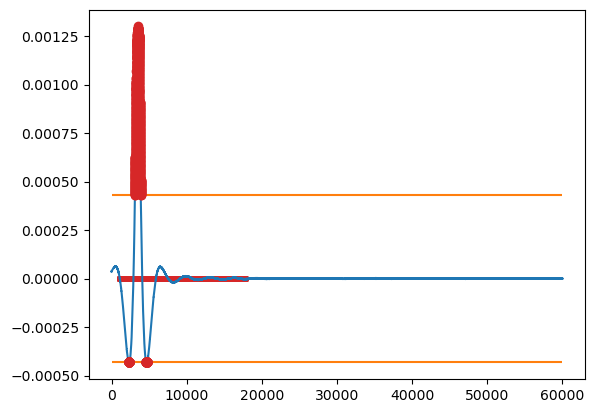

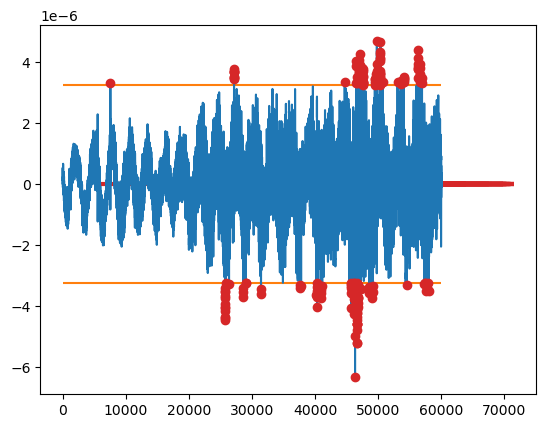

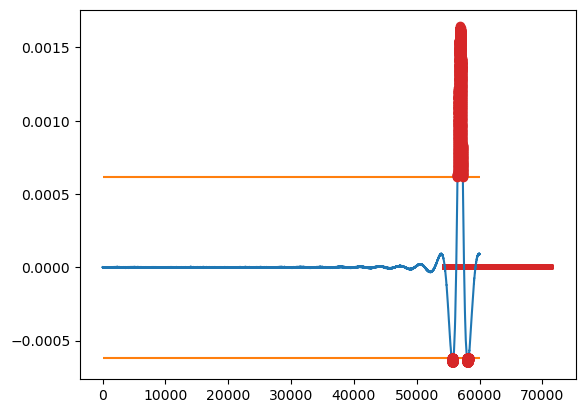

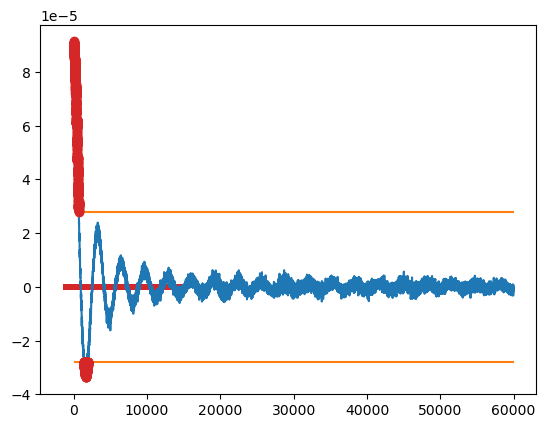

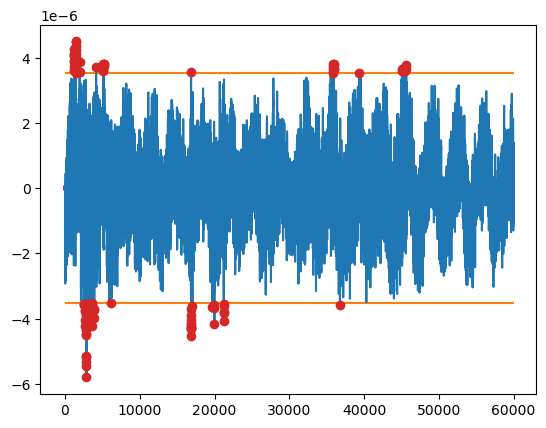

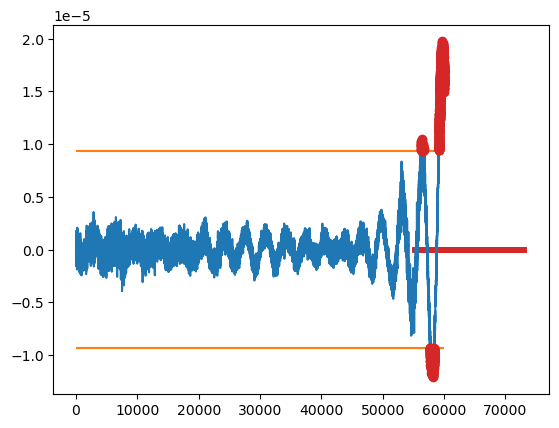

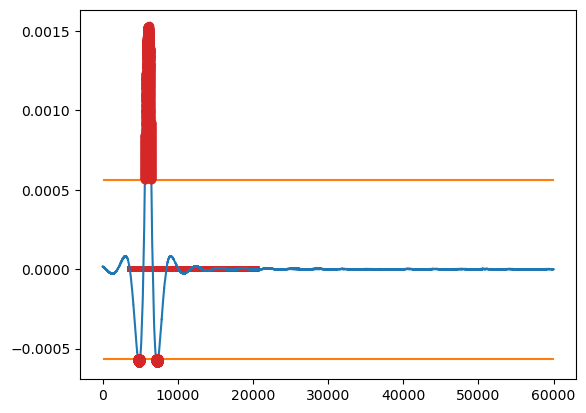

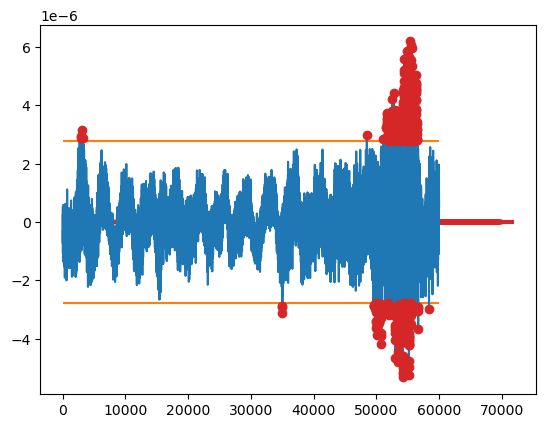

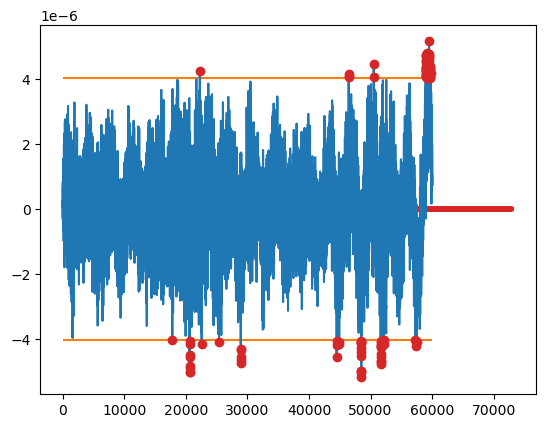

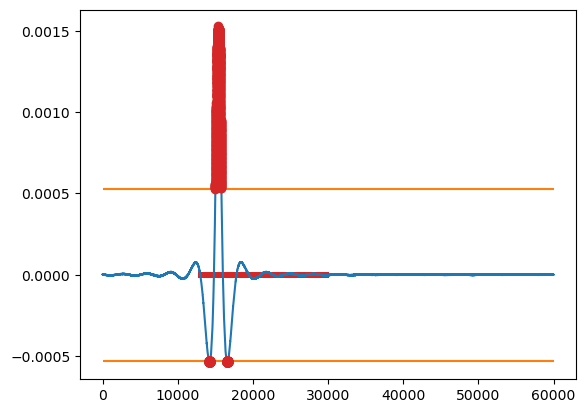

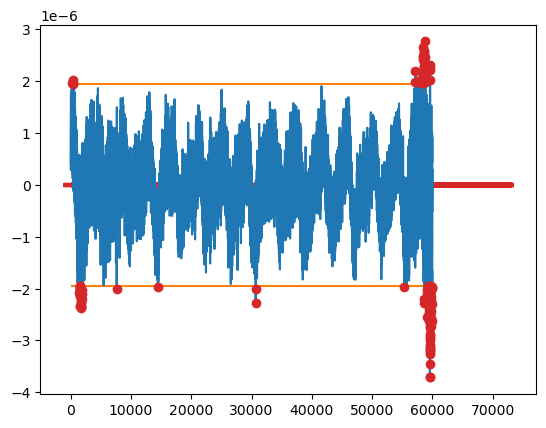

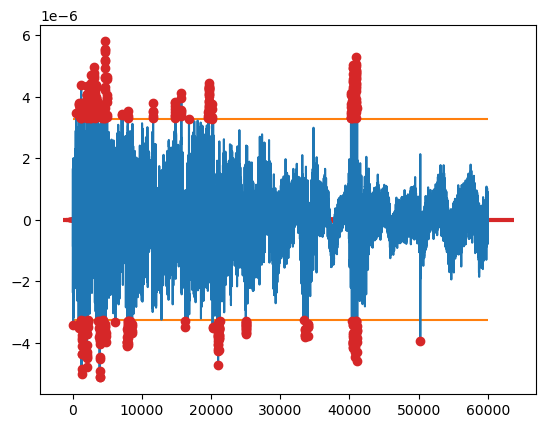

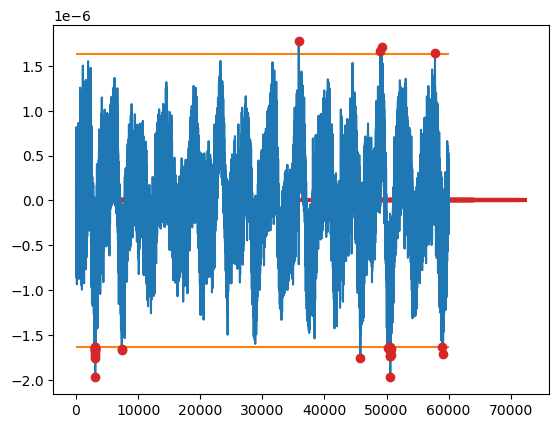

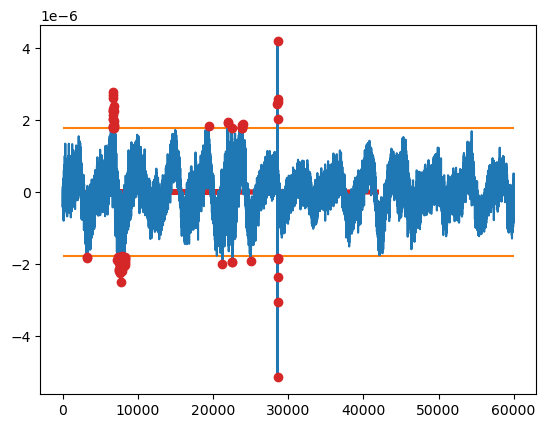

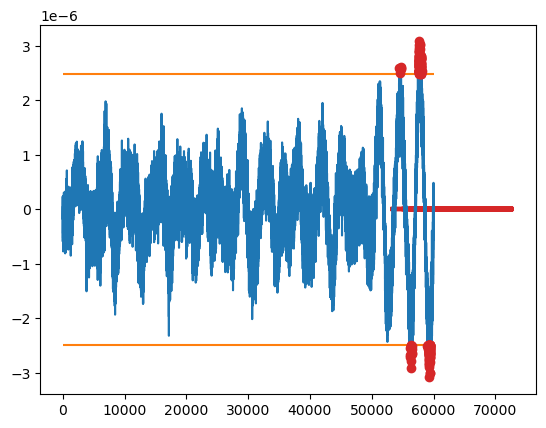

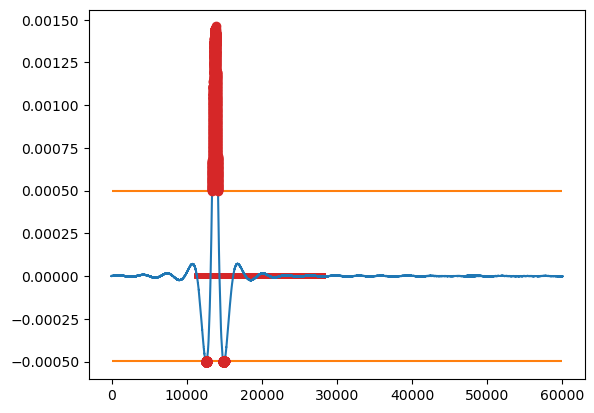

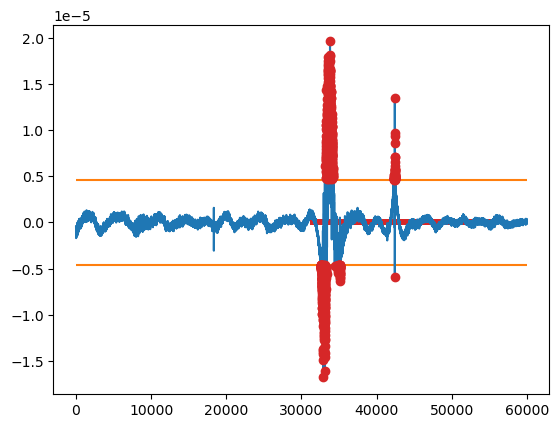

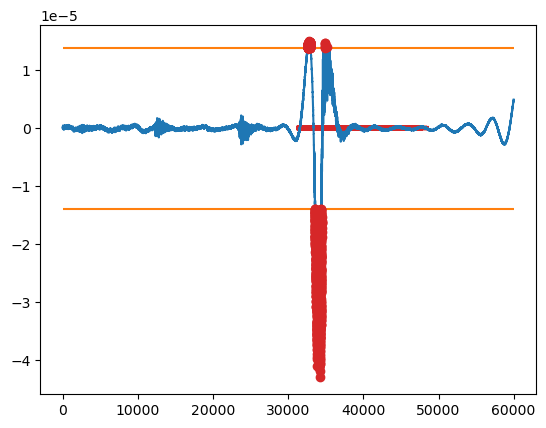

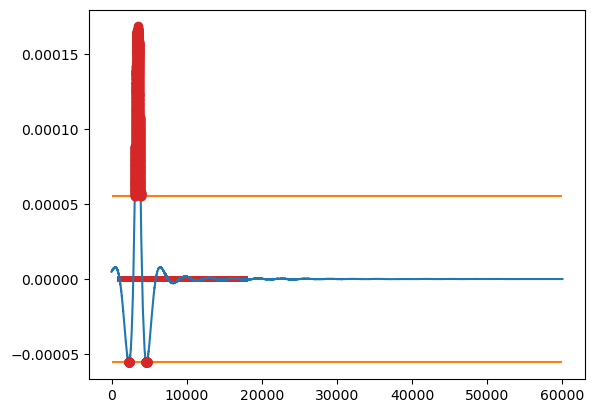

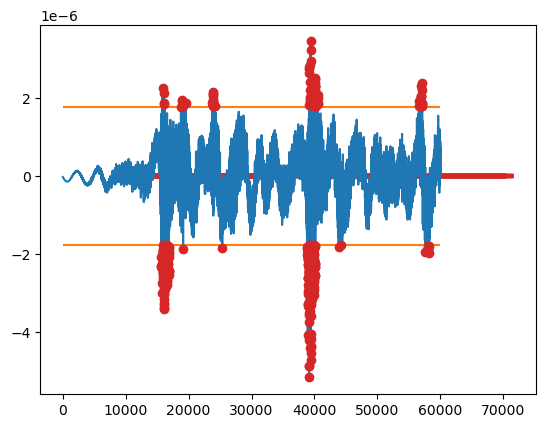

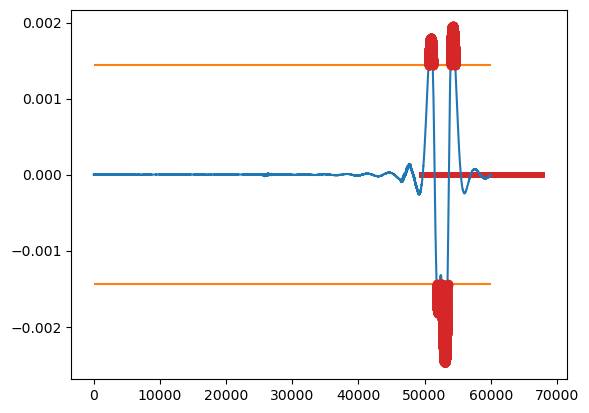

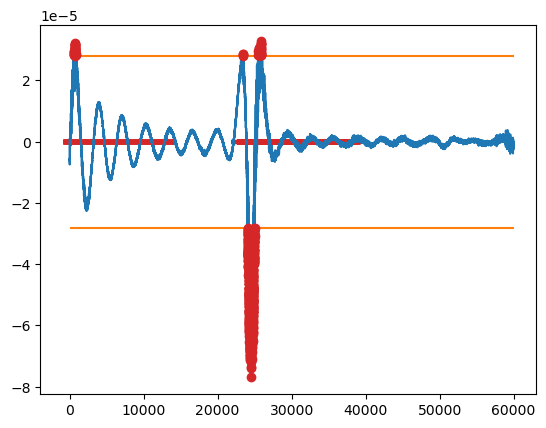

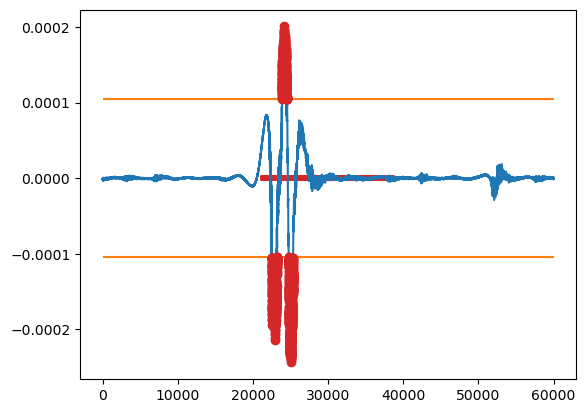

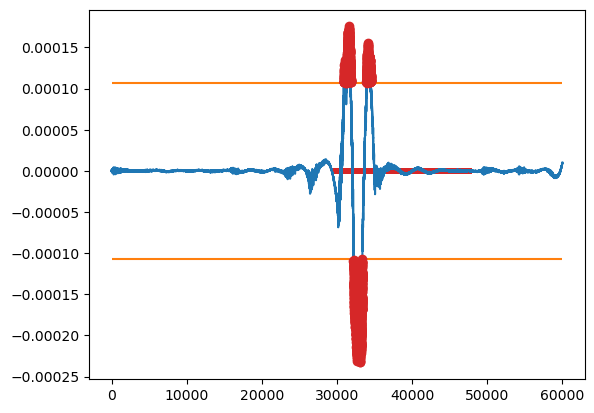

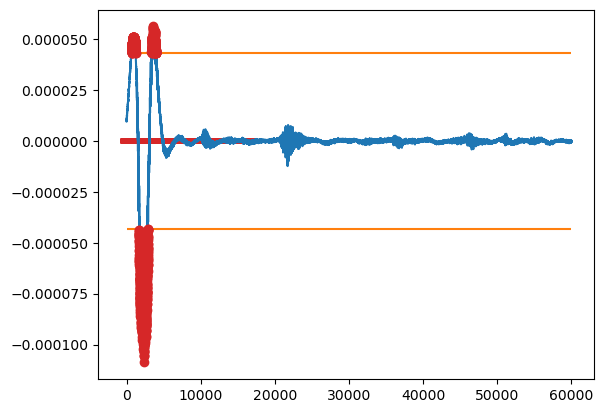

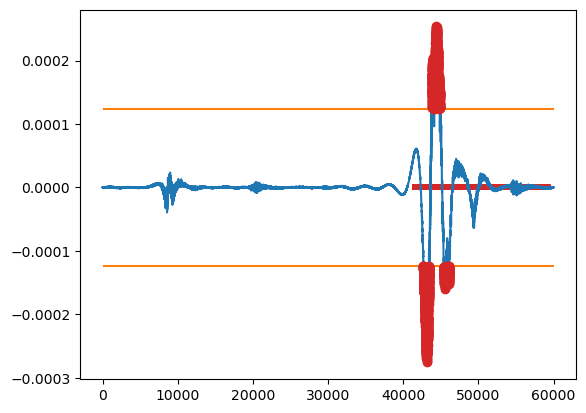

In [345]:
for j in range(len(st)):
    for i in range(math.floor(len(st[j])/(100*10*60))):
        fig = plt.subplots()
        randdata = st[j].data[100*10*60*i:100*10*60*(i+1)]#np.random.normal(size=10000)#*np.exp(np.linspace(0,2,10000))
        randstd1 = np.std(randdata)*3.2
        randstd2 = -np.std(randdata)*3.2
        samples = np.arange(len(randdata))
        plt.plot(samples, randdata)
        plt.hlines(randstd1, 0,len(randdata), color='C1')
        plt.hlines(randstd2, 0,len(randdata), color='C1')
        peaks = samples[(randstd2>randdata) | (randdata>randstd1)]
        plt.plot(peaks, randdata[peaks], linestyle='', marker='o', color='C3')
        # plt.hlines(randdata[peaks], peaks-10*100,peaks+140*100, color='C1')
        # plt.hlines(np.full(len(peaks),randstd), peaks-10*100,peaks+140*100, color='C3', linewidth=3)
        plt.hlines(np.full(len(peaks),0), peaks-15*100,peaks+135*100, color='C3', linewidth=3)

# Ardid

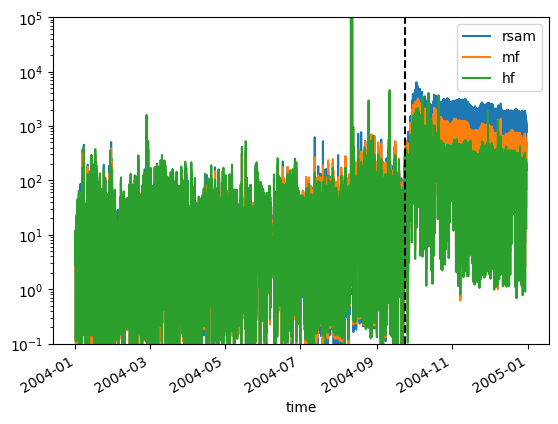

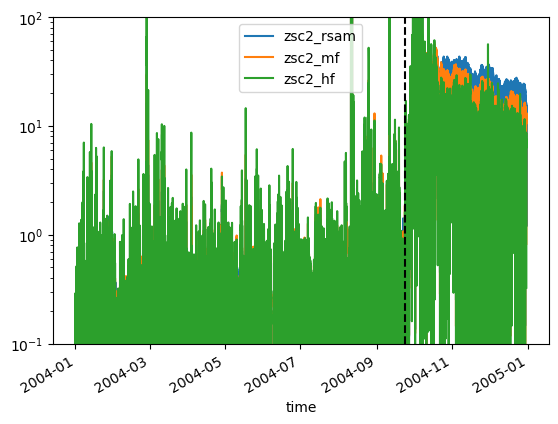

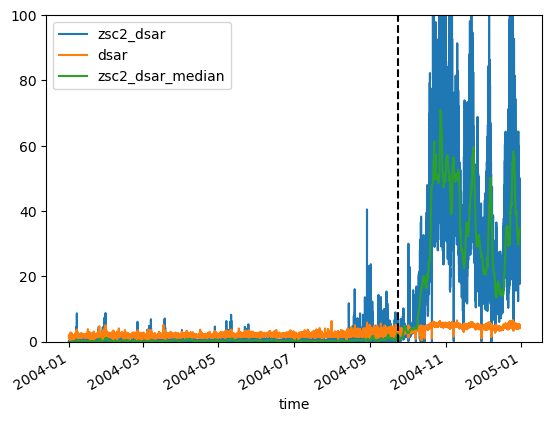

In [559]:
import os
import glob 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from pandas._libs.tslibs.timestamps import Timestamp
try:
    from obspy import UTCDateTime
    failedobspyimport = False
except:
    failedobspyimport = True
         

_MONTH=timedelta(days=365.25/12)
_DAY = timedelta(days=1)

# aux functions 
def datetimeify(t):
    """ Return datetime object corresponding to input string.
        Parameters:
        -----------
        t : str, datetime.datetime
            Date string to convert to datetime object.
        Returns:
        --------
        datetime : datetime.datetime
            Datetime object corresponding to input string.
        Notes:
        ------
        This function tries several datetime string formats, and raises a ValueError if none work.
    """
    if type(t) in [datetime, Timestamp]:
        return t
    if not failedobspyimport:
        if type(t) is UTCDateTime:
            return t._get_datetime()
    fmts = ['%Y-%m-%d %H:%M:%S', '%Y-%m-%d', '%Y %m %d %H %M %S',]
    for fmt in fmts:
        try:
            return datetime.strptime(t, fmt)
        except ValueError:
            pass
    raise ValueError("time data '{:s}' not a recognized format".format(t))

def zsc(s):
    # log transform data
    log_s = np.log10(s).replace([np.inf, -np.inf], np.nan).dropna()
    
    # compute mean/std/min
    mn = np.mean(log_s)
    std = np.std(log_s)
    minzsc = np.min(log_s)                                                    

    # Calculate percentile
    s=(np.log10(s)-mn)/std
    s=s.fillna(minzsc)
    s=10**s
    return s
    
def log_zsc(s):
    return log(zsc(s))

def zsc2(s):
    s=zsc(s)
    s=s.rolling(window=2).min()
    s[0]=s[1]
    return s

def log_zsc2(s):
    return log(zsc2(s))

def main():    
    #load data
#     df = pd.read_csv('../SHW_seismic_data.csv', #pd.read_csv('.'+os.sep+'SHW_seismic_data.csv'
#             usecols=['time','rsam','mf','hf','dsar'],
#             index_col = 'time', infer_datetime_format=True)
#     df.index = pd.to_datetime(df.index)
#     df.sort_index()

    all_files = sorted(glob.glob('../tmp_2004/EDM/*.csv'))
    li = []
    for filename in all_files:
        frame = pd.read_csv(filename)
        li.append(frame)

    df = pd.concat(li, axis=0, ignore_index=True)
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df.sort_index()
    df
    
    #eruption times
    te = '2004 09 23 09 00 00'#'2004 10 01 22 00 00'
    te = datetimeify(te)

    # compute transforms and save
    df['zsc2_rsam'] = zsc2(df['rsam'])
    df['zsc2_mf'] = zsc2(df['mf'])
    df['zsc2_hf'] = zsc2(df['hf'])
    df['zsc2_dsar'] = zsc2(df['dsar'])

    df.to_csv('../EDM_2004_2005.csv') #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')

    # plot some data
    df[['rsam','mf','hf']].plot(ylim=(1e-1,1e5))
    plt.yscale('log')
    plt.axvline(te, color='k', ls = '--')
    plt.show()
    plt.close()
    #
    df[['zsc2_rsam','zsc2_mf','zsc2_hf']].plot(ylim=(1e-1,1e2))
    plt.yscale('log')
    plt.axvline(te, color='k', ls = '--')
    plt.show()
    plt.close()
    #
    df['zsc2_dsar_median'] = df[['zsc2_dsar']].rolling(2*24*6).median()
    df[['zsc2_dsar', 'dsar','zsc2_dsar_median']].plot(ylim=(0,100))
    #_df[['dsar']].rolling(2*24*6).median().plot(ylim=(0,10))
    plt.axvline(te, color='k', ls = '--')
    plt.show()
    plt.close()  

if __name__=='__main__':
    main()    
    

In [551]:
# all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/tmp_2004/*/*.csv'))
all_files = sorted(glob.glob('../tmp_2004/*/*.csv'))
# all_files = all_files[:]
all_files

['../tmp_2004/SHW/SHW_100.csv',
 '../tmp_2004/SHW/SHW_101.csv',
 '../tmp_2004/SHW/SHW_102.csv',
 '../tmp_2004/SHW/SHW_103.csv',
 '../tmp_2004/SHW/SHW_104.csv',
 '../tmp_2004/SHW/SHW_105.csv',
 '../tmp_2004/SHW/SHW_106.csv',
 '../tmp_2004/SHW/SHW_107.csv',
 '../tmp_2004/SHW/SHW_108.csv',
 '../tmp_2004/SHW/SHW_109.csv',
 '../tmp_2004/SHW/SHW_110.csv',
 '../tmp_2004/SHW/SHW_111.csv',
 '../tmp_2004/SHW/SHW_112.csv',
 '../tmp_2004/SHW/SHW_113.csv',
 '../tmp_2004/SHW/SHW_114.csv']

In [553]:
# all_files = sorted(glob.glob('../data/tmp_2004/EDM/_tmp_taper_*.csv'))
# all_files = all_files[242:275]
li = []
for filename in all_files:
    frame = pd.read_csv(filename)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df.sort_index()
df

rsam         mf          hf      dsar
time                                                           
2004-04-09 00:00:00   0.295055   0.275230    0.352584  1.516463
2004-04-09 00:10:00   3.909876   3.827325    4.866816  1.522844
2004-04-09 00:20:00  12.337135  12.191648   15.425177  1.530691
2004-04-09 00:30:00  23.823707  23.942607   29.716865  1.558186
2004-04-09 00:40:00  33.759258  32.896492   42.297689  1.509316
...                        ...        ...         ...       ...
2004-04-23 22:10:00  86.065726  85.656090  110.102068  1.493155
2004-04-23 22:20:00  71.204167  74.212843   94.187618  1.497375
2004-04-23 22:30:00  51.607812  51.206902   64.577243  1.517786
2004-04-23 22:40:00  25.237741  25.634405   32.481459  1.502965
2004-04-23 22:50:00   5.230773   5.342596    6.771867  1.509247

[2125 rows x 4 columns]

In [59]:
import numpy as np
import pandas as pd
import obspy
import obspy.signal.filter
import datetime
import scipy
import glob
import sys
import os
import scipy as sc
import time
import matplotlib.pyplot as plt
import argparse
import warnings
warnings.filterwarnings("ignore")

import multiprocessing
from functools import partial

sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()

# Define all functions---------------------------------------------------

def preprocessing(year,jday, net, sta, cha):

    try:
        # this stream will be used for RSAM and DSAR calculations
        #st = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st = client.get_waveforms(network=net, station=sta, channel=cha,
                                       year='{}'.format(year), doy='{}'.format(jday))

        st.detrend('linear')
        st.taper(max_percentage=None,max_length=5, type='hann') #max_length in sec
        
        # correct insrument response
        inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
        pre_filt = [1e-3, 5e-2, 45, 50]
        water_level = 60
        
        for tr in st:
            tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                                      pre_filt=pre_filt, output="VEL", water_level=water_level,
                                      plot=False)

            # correct positive dip
            dip = inv.get_orientation(tr.id, datetime=tr.stats.starttime)['dip']
            if dip > 0:
                tr.data *= -1
#         st.merge(fill_value=0)
        print(':) year={}, jday={}, net={}, sta={}, cha={}'.format(year,jday, net, sta, cha))
    except:
        print('pass station {} day {}'.format(sta,jday))
    return(st)
    
def noise_analysis(data, datas, samp_rate, N, Nm):
    rms_list = []
    rmes_list = []
    pgv_list = []
    pga_list = []

    for i in np.arange(0,Nm,N): # start samples (sample, where next 10min starts)
        data_cut = data[i:i+N-1]

        rms = np.sqrt(np.mean(data_cut**2))
        rmes = np.sqrt(np.median(data_cut**2))
        pgv = max(abs(data_cut))

        data_acc = (data_cut.copy()[:-1] - data_cut.copy()[1:]) / (1/samp_rate)
        pga = max(abs(data_acc))

        rms_list.append(rms)
        rmes_list.append(rmes)
        pgv_list.append(pgv)
        pga_list.append(pga)
    datas.append(np.array(rms_list))
    datas.append(np.array(rmes_list))
    datas.append(np.array(pgv_list))
    datas.append(np.array(pga_list))
    return (datas)
    
def RSAM(data, samp_rate, datas, freq, Nm, N):
    filtered_data = obspy.signal.filter.bandpass(data, freq[0], freq[1], samp_rate)
    filtered_data = abs(filtered_data[:Nm])
    datas.append(filtered_data.reshape(-1,N).mean(axis=-1)*1.e9)
    return(datas)

def VSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute ratio between different velocities
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('hf')
    hfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    hfd = abs(hfd[:Nm])
    hfd = hfd.reshape(-1,N).mean(axis=-1)
    vsar = mfd/hfd
    datas.append(vsar)
    return(datas)

def DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute dsar
    data = scipy.integrate.cumtrapz(data, dx=1./100, initial=0) # vel to disp
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('hf')
    hfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    hfd = abs(hfd[:Nm])
    hfd = hfd.reshape(-1,N).mean(axis=-1)
    dsar = mfd/hfd
    datas.append(dsar)
    return(datas)

def lDSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute dsar for low frequencies
    data = scipy.integrate.cumtrapz(data, dx=1./100, initial=0) # vel to disp
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('rsam')
    lfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    lfd = abs(lfd[:Nm])
    lfd = lfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    ldsar = lfd/mfd
    datas.append(ldsar)
    return(datas)

def nDSAR(datas):
    dsar = datas[3]
    ndsar = dsar/sc.stats.zscore(dsar)
    datas.append(ndsar)
    return(datas)
    
# creates a df for each trace and append this df to a daily df
# def create_df(datas, ti, freqs_names, df):
#     datas = np.array(datas)
#     time = [(ti+j*600).datetime for j in range(datas.shape[1])]
#     df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
#     df = pd.concat([df, df_tr])
#     return(df)    

def create_df(datas, ti, freqs_names, df):
    datas = np.array(datas)
    time = [(ti+j*600).datetime for j in range(datas.shape[1])]
    df_tr = pd.DataFrame(zip(*datas), columns=freqs_names+['rms','rmes','pgv','pga'], index=pd.Series(time))
    df = pd.concat([df, df_tr])
    return(df) 
    
# main function..............................................................................
def freq_bands_taper(jday, year, netstacha):   
    ''' 
    calculate and store power in 10 min long time windows for different frequency bands
    sensor measured ground velocity
    freqs: list contains min and max frequency in Hz
    dsar: float represents displacement (integration of)'''
    
    net = netstacha.split('-')[0]
    sta = netstacha.split('-')[1]
    cha = netstacha.split('-')[2]
    
    file_path = '../tmp_{}/{}/'.format(year, sta)
    file_name = '{}_{}.csv'.format(sta,jday)
        
    if os.path.isfile(file_path+file_name):
        print('file for {}-{} at {} already exist'.format(year,jday, netstacha))
        pass
    else:    
        if not os.path.exists(file_path):
            os.makedirs(file_path)

        start_time = time.time()
        freqs_names = ['rsam','mf','hf','dsar','ldsar', 'vsar']
        df = pd.DataFrame(columns=freqs_names)
        daysec = 24*3600
        freqs = [[2,5], [4.5,8], [8,16]]

        st = preprocessing(year,jday, net, sta, cha)

        if len(st)>0: # if stream not empty
    #         st.resample(50)
            for tr in st:
    #         tr = st[0]
                datas = []
                data = tr.data
                samp_rate = tr.meta['sampling_rate']
                ti = tr.meta['starttime']
                # round start time to nearest 10 min increment
                tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
                ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
                N = int(600*samp_rate)    # 10 minute windows in seconds
                Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
                # seconds per day (86400) * sampling rate (100) -> datapoints per day

                for freq, frequ_name in zip(freqs, freqs_names[:3]):
                    datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

                datas = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
                datas = lDSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
                datas = VSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
    #             datas = nDSAR(datas) # --> add ndsar in freqs_names

                datas = noise_analysis(data, datas, samp_rate, N, Nm)

                df = create_df(datas, ti, freqs_names, df)

            df.to_csv(file_path + file_name, index=True, index_label='time')
            print('One day tooks {} seconds.'.format(round(time.time()-start_time),3))
    return()



# multi processing for several station -----------------------------------------------------------------------------

# parser = argparse.ArgumentParser(description='Calculate different frequency bands of RSMA and DSAR.')
# parser.add_argument('year', type=int, help='Year of interest')
# parser.add_argument('start_day', type=int, help='Julian day you want to start')
# parser.add_argument('end_day', type=int, help='Julian day +1 you want to end')

# args = parser.parse_args()

# year = args.year
# jdays = ['{:03d}'.format(jday) for jday in range(args.start_day,args.end_day)]

In [60]:
# stations as string 'network-station-channel'
s1  = 'UW-EDM-EHZ'
s2  = 'UW-SHW-EHZ'
s3  = 'UW-HSR-EHZ'
s4  = 'UW-SOS-EHZ'
s5  = 'UW-JUN-EHZ'
s6  = 'UW-ELK-EHZ'
s7  = 'UW-TDL-EHZ'
s8  = 'UW-SUG-EHZ'
s9  = 'UW-YEL-EHZ'
s10 = 'UW-FL2-EHZ'
s11 = 'UW-CDF-?H?'

s12 = 'UW-SEP-?H?'
s13 = 'CC-SEP-?H?'
# s14 = 'UW-STD-EHZ'
s15 = 'CC-STD-BHZ'

s16 = 'CC-VALT-BH?'
s17 = 'CC-JRO-BHZ'
s18 = 'CC-HOA-BH?'
s19 = 'CC-LOO-BH?'
s20 = 'CC-USFR-BH?'
s21 = 'CC-NED-EHZ'
s22 = 'CC-REM-BH?'
s23 = 'CC-SWFL-BH?'
s24 = 'CC-SFW2-BH?'
s25 = 'CC-MIDE-EHZ'
s26 = 'CC-MIBL-EHZ'
s27 = 'CC-BLIS-EHZ'
s28 = 'CC-RAFT-EHZ'
s29 = 'CC-SPN5-EHZ'
s30 = 'CC-SEND-EHZ'

list_stations = [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,
                 s15,s16,s17,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27,s28,s29,s30] # make a list of all stations

In [62]:
year = 2004
jdays = ['{:03d}'.format(jday) for jday in range(1,2+1)]
for netstacha in list_stations:
    print('Station {}'.format(netstacha))
    stime = time.time()
    for jday in jdays:
        freq_bands_taper(year=year, netstacha=netstacha, jday=jday)

        print('Calculation tooks {} seconds.'.format(round(time.time()-stime),3))

# comment parser out
#--> python RSAM_DSAR.py 2004 1 366

Station UW-EDM-EHZ
file for 2004-001 at UW-EDM-EHZ already exist
Calculation tooks 0 seconds.
file for 2004-002 at UW-EDM-EHZ already exist
Calculation tooks 0 seconds.
Station UW-SHW-EHZ
file for 2004-001 at UW-SHW-EHZ already exist
Calculation tooks 0 seconds.
:) year=2004, jday=002, net=UW, sta=SHW, cha=EHZ
One day tooks 32 seconds.
Calculation tooks 32 seconds.
Station UW-HSR-EHZ
pass station HSR day 001
One day tooks 10 seconds.
Calculation tooks 10 seconds.
pass station HSR day 002
One day tooks 8 seconds.
Calculation tooks 18 seconds.
Station UW-SOS-EHZ
:) year=2004, jday=001, net=UW, sta=SOS, cha=EHZ
One day tooks 50 seconds.
Calculation tooks 50 seconds.
:) year=2004, jday=002, net=UW, sta=SOS, cha=EHZ
One day tooks 28 seconds.
Calculation tooks 78 seconds.
Station UW-JUN-EHZ
:) year=2004, jday=001, net=UW, sta=JUN, cha=EHZ
One day tooks 33 seconds.
Calculation tooks 33 seconds.
:) year=2004, jday=002, net=UW, sta=JUN, cha=EHZ
One day tooks 30 seconds.
Calculation tooks 63 sec

In [58]:
file_path = '../tmp_{}/{}/'.format(2004, 'EDM')
file_name = '{}_{}.csv'.format('EDM','001')

print(file_path+file_name)

if os.path.isfile(file_path+file_name):
    print('file for {}-{} at  already exist'.format(year,jday))
    pass
else:
    print('does not exist')

../tmp_2004/EDM/EDM_001.csv
does not exist
